# Part I: Cellular Automata & Wolfram’s Four-Class Scheme

## 1.1 A Universe in One Dimension: Defining Elementary Cellular Automata (ECA)

Elementary Cellular Automata (ECA) are among the simplest discrete dynamical systems. They are defined by three ingredients:

  - **1D lattice**: a linear array of cells.
  - **Binary states**: each cell is either 0 (white) or 1 (black).
  - **Local update rule**: at each discrete time step, a cell’s next state depends only on itself and its two nearest neighbors (left and right).

This neighborhood has 3 cells, each binary, so there are $2^3 = 8$ possible neighborhood patterns (from **111** down to **000**). For each of these 8 patterns, the rule specifies the next state (0 or 1) of the **center** cell. Hence the total number of distinct rules is
$$2^{(2^3)} = 256.$$
These rules are indexed by the **Wolfram code** (0–255), which reads the 8 output bits in the fixed neighborhood order
\`\` and interprets them as an 8-bit binary number.

In [3]:
import numpy as np

def rule_to_lookup(rule_number):
    """
    Convert a Wolfram rule number (0–255) into a lookup table.

    Parameters:
        rule_number (int): ECA rule number, an integer between 0 and 255.

    Returns:
        dict: A dictionary mapping the 8 possible neighborhood tuples 
              (e.g., (1, 1, 1)) to their corresponding output states (0 or 1).
    """
    if not 0 <= rule_number <= 255:
        raise ValueError("Rule number must be between 0 and 255.")

    # Convert the rule number to an 8-bit binary string
    # '08b' ensures the output has 8 bits with leading zeros if necessary
    binary_string = format(rule_number, '08b')

    # Wolfram’s standard neighborhood ordering
    neighborhoods = [
        (1, 1, 1), (1, 1, 0), (1, 0, 1), (1, 0, 0),
        (0, 1, 1), (0, 1, 0), (0, 0, 1), (0, 0, 0)
    ]

    # Create the lookup table dictionary
    # Map each neighborhood to the corresponding bit in the binary rule string
    lookup_table = {neighborhoods[i]: int(binary_string[i]) for i in range(8)}

    return lookup_table


# --- Example Usage ---
# Generate a lookup table for Rule 30
rule_30_table = rule_to_lookup(30)

# Print the results for verification
# Rule 30 binary representation is 00011110
print(f"Rule 30 ({format(30, '08b')}) lookup table:")
for neighborhood, output in rule_30_table.items():
    print(f"Neighborhood {neighborhood} -> Output {output}")

# --- Example Usage ---
# Generate a lookup table for Rule 90
rule_90_table = rule_to_lookup(90)

# Print the results for verification
# Rule 90 binary representation is 01011010
print(f"\nRule 90 ({format(90, '08b')}) lookup table:")
for neighborhood, output in rule_90_table.items():
    print(f"Neighborhood {neighborhood} -> Output {output}")


Rule 30 (00011110) lookup table:
Neighborhood (1, 1, 1) -> Output 0
Neighborhood (1, 1, 0) -> Output 0
Neighborhood (1, 0, 1) -> Output 0
Neighborhood (1, 0, 0) -> Output 1
Neighborhood (0, 1, 1) -> Output 1
Neighborhood (0, 1, 0) -> Output 1
Neighborhood (0, 0, 1) -> Output 1
Neighborhood (0, 0, 0) -> Output 0

Rule 90 (01011010) lookup table:
Neighborhood (1, 1, 1) -> Output 0
Neighborhood (1, 1, 0) -> Output 1
Neighborhood (1, 0, 1) -> Output 0
Neighborhood (1, 0, 0) -> Output 1
Neighborhood (0, 1, 1) -> Output 1
Neighborhood (0, 1, 0) -> Output 0
Neighborhood (0, 0, 1) -> Output 1
Neighborhood (0, 0, 0) -> Output 0


### 1.2 The Taxonomy of Complexity: Wolfram’s Phenomenological Classification

Stephen Wolfram, through extensive observation of spatiotemporal patterns emerging from Elementary Cellular Automata (ECA) with random initial conditions, proposed a **four-class phenomenological taxonomy** of dynamical behavior.  
This classification is *phenomenological*—it relies on qualitative observation of system behavior rather than formal quantitative measures.

- **Class 1 — Homogeneous Behavior**:  
  The system rapidly evolves into a uniform, stable state (e.g., all cells become 0).  
  It represents “death” or stasis.

- **Class 2 — Periodic/Stable Patterns**:  
  The system develops simple, repetitive, and predictable structures, leading to ordered behavior.

- **Class 3 — Chaotic Dynamics**:  
  The system exhibits disordered, aperiodic patterns that appear random.  
  Small changes in initial conditions lead to drastically different outcomes—hallmarks of chaos.

- **Class 4 — Complex, Localized Structures**:  
  The system produces persistent, interacting localized structures that propagate and evolve over time.  
  This “edge of chaos” regime lies between order and randomness and is often associated with complex computation.

Wolfram’s phenomenological framework provides a foundation for understanding how simple rules can generate complex behavior.  
However, it is inherently **subjective**—distinguishing between true chaos (Class 3) and long transients that eventually settle into order (Class 4) can be difficult by visual inspection alone.  

This is exactly the motivation of the paper we are reproducing:  
to transform this **qualitative, observation-based taxonomy** into a **quantitative and automatable metric**, allowing for objective classification of cellular automata dynamics.  
In other words, the goal is to move from *observation* to *measurement*—analogous to replacing “hot” and “cold” with a thermometer reading.

---

The following code implements a core **ECA evolution function** `evolve_eca()`,  
which simulates the temporal evolution of an elementary cellular automaton.  
We will use it to reproduce Figure 1 from the paper, showing typical representatives of the four Wolfram classes:

| Class | Representative Rule | Description |
|:------|:--------------------|:-------------|
| I | Rule 40 | Uniform convergence |
| II | Rule 6  | Periodic structures |
| III | Rule 30 | Chaotic behavior |
| IV | Rule 54 | Complex interactions |

Each simulation starts from a random initial configuration (each cell having a 50% probability of being 0 or 1)  
and uses **periodic boundary conditions** (the array wraps around at edges).  
This visualization step provides the intuitive grounding for later, quantitative analysis using **Hamming distance** metrics.


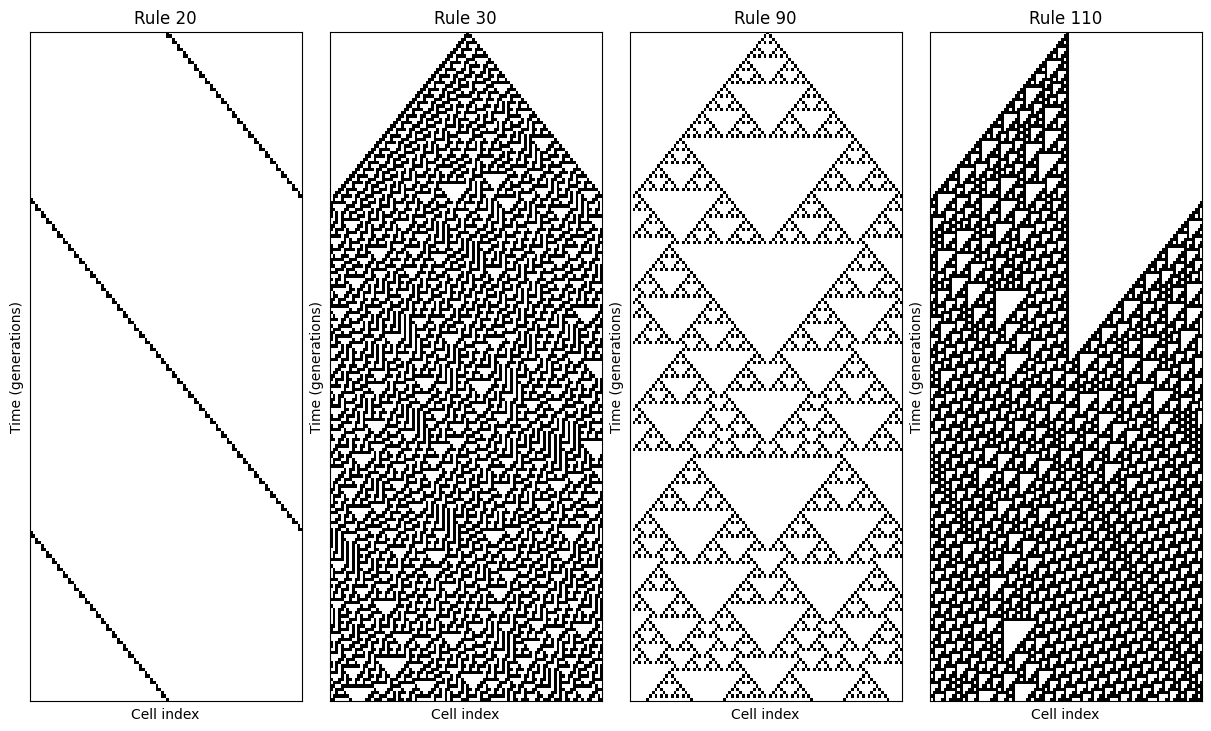

Generating space–time diagrams for rules: [20, 30, 90, 110]


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

# ==============================================================================
# Module 1: Cellular Automaton Simulator and Multi-Rule Visualization
# ==============================================================================

class ElementaryCellularAutomaton:
    """A simulator for Elementary Cellular Automata (ECA)."""
    def __init__(self, rule_number: int, size: int = 100):
        if not isinstance(rule_number, int) or not (0 <= rule_number <= 255):
            raise ValueError("Rule number must be an integer between 0 and 255.")
        if size <= 0:
            raise ValueError("size must be a positive integer.")

        self.rule_number = rule_number
        self.size = int(size)
        # Wolfram ordering [111,110,101,100,011,010,001,000] as an 8-bit array (MSB->LSB)
        self.rule_table = np.array([int(x) for x in f"{rule_number:08b}"], dtype=np.uint8)
        self.state = None
        self.history = []

    def initialize(self, initial_state: np.ndarray = None, center_impulse: bool = False, seed: int | None = 42):
        """
        Initialize the automaton state.

        Parameters
        ----------
        initial_state : np.ndarray, optional
            1D array of 0/1. If None, a random state is created (unless center_impulse=True).
        center_impulse : bool, default False
            If True, ignore initial_state and use a zero array with a single 1 at the center.
        seed : int or None
            RNG seed for reproducibility when generating random initial states.
        """
        if center_impulse:
            self.state = np.zeros(self.size, dtype=np.uint8)
            self.state[self.size // 2] = 1
        else:
            if initial_state is None:
                if seed is not None:
                    np.random.seed(seed)
                self.state = np.random.randint(0, 2, self.size, dtype=np.uint8)
            else:
                arr = np.asarray(initial_state, dtype=np.uint8)
                if arr.ndim != 1 or len(arr) != self.size:
                    raise ValueError(f"initial_state must be a 1D array of length {self.size}.")
                self.state = arr
        self.history = [self.state.copy()]

    def evolve(self, steps: int = 1):
        """Evolve the automaton for a given number of steps under periodic boundary conditions."""
        if self.state is None:
            raise RuntimeError("Call initialize() before evolve().")
        if steps < 1:
            return

        for _ in range(steps):
            left  = np.roll(self.state,  1)
            right = np.roll(self.state, -1)
            # Encode (l,c,r) as a 3-bit index: l*4 + c*2 + r*1 (111 -> 7, ..., 000 -> 0)
            idx = (left << 2) | (self.state << 1) | right
            # rule_table is ordered [111..000] -> indices 0..7, so map by (7 - idx)
            self.state = self.rule_table[7 - idx]
            self.history.append(self.state.copy())


def plot_evolution(history: np.ndarray, rule_number: int, ax=None, title_prefix: str = "Rule"):
    """Plot a single space–time diagram."""
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(history, cmap="binary", interpolation="nearest", aspect="auto")
    ax.set_title(f"{title_prefix} {rule_number}", fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("Cell index")
    ax.set_ylabel("Time (generations)")
    return ax


def _grid(n_items: int, max_cols: int = 4):
    """Compute (rows, cols) for a near-square grid with up to max_cols columns."""
    cols = min(max_cols, max(1, n_items))
    rows = ceil(n_items / cols)
    # Try to make it as square as possible by reducing columns if the last row would be too sparse
    while (rows - 1) * cols >= n_items and cols > 1:
        cols -= 1
        rows = ceil(n_items / cols)
    return rows, cols


def visualize_rules_single_row(
    rules,
    size: int = 100,
    steps: int = 500,
    center_impulse: bool = True,
    seed=None,
    figsize_unit: float = 3.0,
):
    import numpy as np
    import matplotlib.pyplot as plt

    rules = list(rules)
    if len(rules) == 0:
        raise ValueError("Provide at least one rule number.")

    cols = len(rules)
    rows = 1
    # 宽度按规则数线性扩展；高度按步数/尺寸的高宽比做一点伸缩，避免过矮/过高
    fig_w = max(6.0, cols * figsize_unit)
    fig_h = max(2.5, rows * figsize_unit * (steps / max(size, 1)) * 1.2)

    fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h), constrained_layout=True)
    axes = np.atleast_1d(axes).ravel()

    histories = {}
    for ax, rule in zip(axes, rules):
        eca = ElementaryCellularAutomaton(rule_number=int(rule), size=size)
        eca.initialize(center_impulse=center_impulse, seed=seed)
        eca.evolve(steps=steps)
        hist = np.array(eca.history, dtype=np.uint8)
        histories[rule] = hist
        plot_evolution(hist, rule, ax=ax)

    plt.show()
    return histories

RULES = [20, 30, 90, 110]
_ = visualize_rules_single_row(RULES, size=100, steps=200, center_impulse=True)

print(f"Generating space–time diagrams for rules: {RULES}")

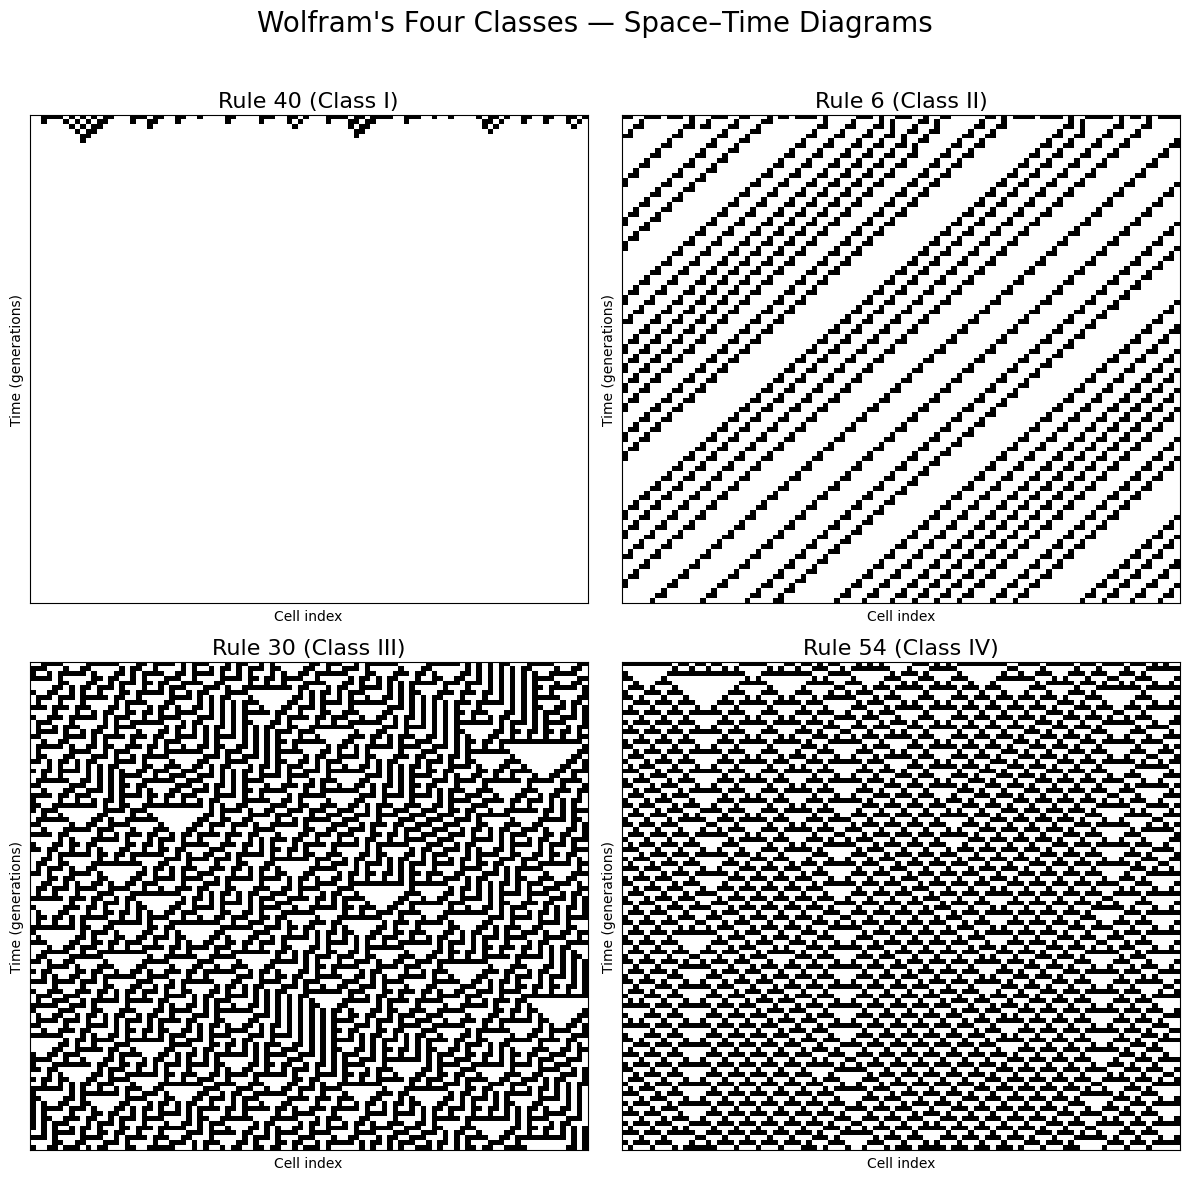

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# --- Global parameters (aligned with the paper) ---
LATTICE_SIZE = 100
ITERATIONS   = 100
RANDOM_SEED  = 42  # for reproducibility; set to None for fresh randomness

# --- Core utilities ---

def rule_to_lookup(rule_number: int):
    """
    Convert a Wolfram ECA rule number (0–255) into a lookup table (dict).

    Parameters
    ----------
    rule_number : int
        Wolfram code in [0, 255].

    Returns
    -------
    dict
        Maps the 8 neighborhood tuples (l, c, r) to outputs {0, 1}, using
        Wolfram's neighborhood order: [111, 110, 101, 100, 011, 010, 001, 000].
    """
    if not isinstance(rule_number, int) or not (0 <= rule_number <= 255):
        raise ValueError("rule_number must be an integer in [0, 255].")

    binary_string = format(rule_number, "08b")
    neighborhoods = [
        (1, 1, 1), (1, 1, 0), (1, 0, 1), (1, 0, 0),
        (0, 1, 1), (0, 1, 0), (0, 0, 1), (0, 0, 0),
    ]
    return {neighborhoods[i]: int(binary_string[i]) for i in range(8)}


def evolve_eca(rule_number: int, initial_state: np.ndarray, steps: int) -> np.ndarray:
    """
    Evolve a 1D Elementary Cellular Automaton under periodic boundary conditions.

    Parameters
    ----------
    rule_number : int
        Wolfram rule code in [0, 255].
    initial_state : np.ndarray
        1D array of 0/1 integers representing the initial configuration.
    steps : int
        Number of time steps (rows in the returned space–time diagram).

    Returns
    -------
    np.ndarray
        2D array of shape (steps, size). Each row is one generation.
    """
    lookup_table = rule_to_lookup(rule_number)
    size = int(len(initial_state))

    history = np.zeros((steps, size), dtype=np.int8)
    history[0, :] = initial_state

    current = initial_state.copy()
    for t in range(1, steps):
        left  = np.roll(current,  1)
        right = np.roll(current, -1)

        next_gen = np.empty(size, dtype=np.int8)
        for i in range(size):
            neighborhood = (left[i], current[i], right[i])
            next_gen[i] = lookup_table[neighborhood]

        history[t, :] = next_gen
        current = next_gen

    return history


# --- Visualization ---

def plot_wolfram_classes():
    """
    Simulate and visualize representatives of Wolfram's four classes:
    Rule 40 (Class I), Rule 6 (Class II), Rule 30 (Class III), Rule 54 (Class IV).
    Uses random initial conditions and periodic boundary conditions.
    """
    if RANDOM_SEED is not None:
        np.random.seed(RANDOM_SEED)

    rules_to_plot = {
        "Rule 40 (Class I)": 40,
        "Rule 6 (Class II)": 6,
        "Rule 30 (Class III)": 30,
        "Rule 54 (Class IV)": 54,
    }

    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()

    for ax, (title, rule_num) in zip(axes, rules_to_plot.items()):
        initial_state = np.random.randint(2, size=LATTICE_SIZE, dtype=np.int8)
        history = evolve_eca(rule_num, initial_state, ITERATIONS)

        im = ax.imshow(history, cmap="binary", interpolation="nearest", aspect="auto")
        ax.set_title(title, fontsize=16)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel("Cell index")
        ax.set_ylabel("Time (generations)")

    fig.suptitle("Wolfram's Four Classes — Space–Time Diagrams", fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# --- Run visualization ---
plot_wolfram_classes()

# Part II: A New Classification Perspective: The Hamming Distance Method

## 2.1 Quantifying Difference: From Perturbation to Hamming Distance

The core idea of the new method proposed in the paper is to shift focus from observing the evolution pattern of a single system to analyzing its response to a minute perturbation. By measuring how a tiny change (a perturbation) propagates through the system, we can quantify its sensitivity to initial conditions—a key feature that distinguishes different dynamical behaviors, especially order from chaos.[1]

To achieve this, two core concepts are introduced:

*   **Difference Pattern**: Imagine two ECA systems evolving from nearly identical initial conditions. At any given time step, the **Difference Pattern** is the set of cells where their states differ. Computationally, this is equivalent to performing a bitwise XOR operation on the two systems' state vectors.

*   **Hamming Distance**: Originally introduced by Richard Hamming in information theory, the Hamming Distance measures the number of positions at which two strings of equal length are different. In the context of ECA, it is simply the total number of differing cells between the two systems at a given moment—in other words, the number of `1`s in the difference pattern. By calculating this distance at each time step, we generate a time series, $H(t)$.

This method is essentially a dimensionality reduction technique. The complete state of an ECA with 100 cells is a 100-dimensional binary vector, and its spacetime evolution is a complex 2D image. The Hamming distance, $H(t)$, compresses this high-dimensional state at each time step into a single scalar value. The paper's central thesis is that this seemingly simple, low-dimensional time series retains crucial information sufficient to distinguish between the four fundamental dynamical classes. It directly measures how the "information" from the initial perturbation propagates, converges, or dissipates within the system, thereby providing a quantitative "fingerprint" of the system's underlying dynamics.

## 2.2 Experimental Procedure

To generate the Hamming distance time series for any given ECA rule, the paper outlines the following rigorous experimental procedure:

1.  **Initialization**: Create two identical ECA systems, designated `System A` and `System B`. They must share the same random initial state and the same lattice size, $L$.
2.  **Transient Evolution**: Evolve both systems synchronously for a brief period (the paper suggests approximately 15 time steps). The purpose of this step is to allow the systems to move from their initial random state onto their typical dynamical trajectory.
3.  **Apply Perturbation**: After the transient evolution (e.g., at time step $t=15$), apply a single-point perturbation to `System B` by flipping the state of its central cell ($L/2$) (i.e., 0 becomes 1, or 1 becomes 0). At this moment, `System A` and `System B` differ by only one cell.
4.  **Synchronous Evolution and Measurement**: From the point of perturbation onward, continue to evolve both systems synchronously. At each subsequent time step $t$, calculate the Hamming distance between the states of `System A` and `System B`.
5.  **Generate Time Series**: Record the calculated Hamming distance at each step to form the time series $H(t)$.

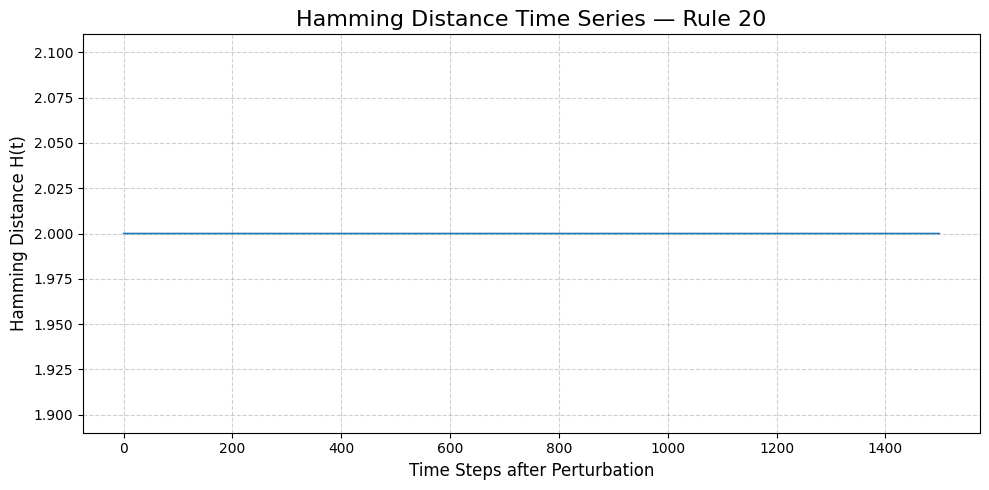

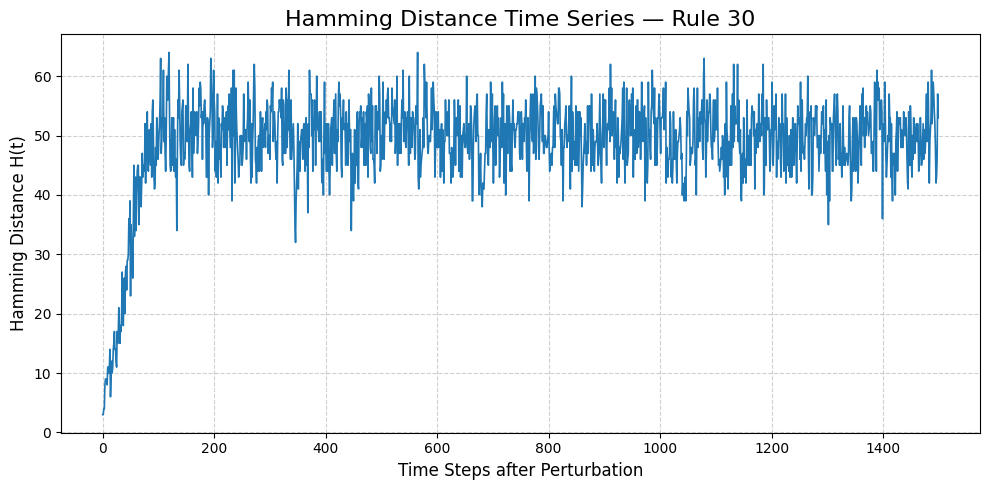

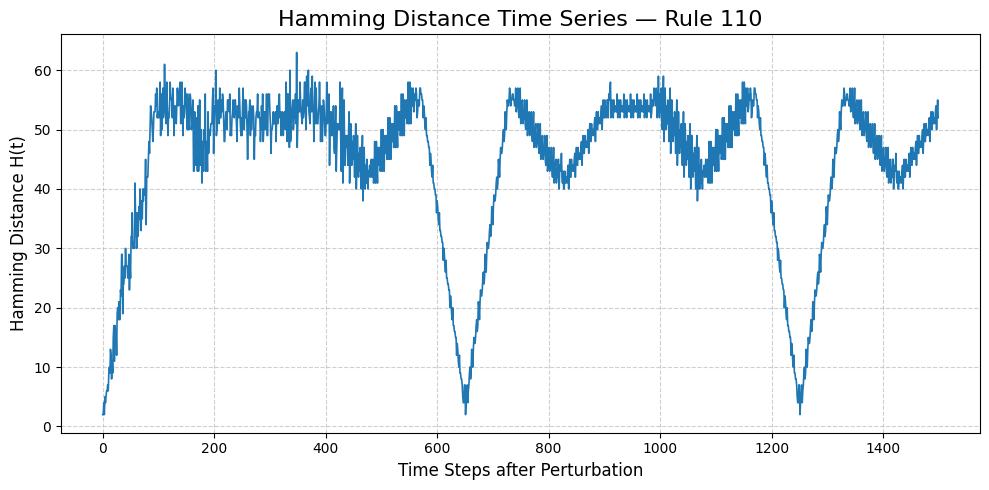

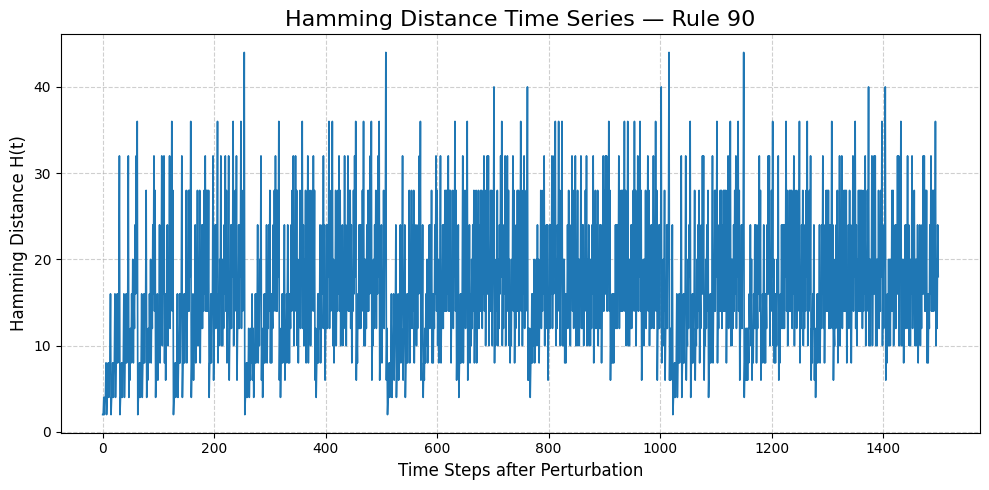

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# --- Global parameters ---
LATTICE_SIZE = 100
HAMMING_ITERATIONS = 1500
TRANSIENT_STEPS = 15

# --- Core simulation functions ---
def rule_to_lookup(rule_number):
    binary = format(rule_number, '08b')
    neighborhoods = [
        (1,1,1),(1,1,0),(1,0,1),(1,0,0),
        (0,1,1),(0,1,0),(0,0,1),(0,0,0)
    ]
    return {n: int(binary[i]) for i, n in enumerate(neighborhoods)}

def evolve_single_step(state, table):
    left, right = np.roll(state, 1), np.roll(state, -1)
    return np.array([table[(l, c, r)] for l, c, r in zip(left, state, right)], dtype=np.int8)


# --- Hamming experiment core ---
def run_hamming_experiment(rule, size=LATTICE_SIZE, steps=HAMMING_ITERATIONS, transient=TRANSIENT_STEPS):
    table = rule_to_lookup(rule)
    a = np.random.randint(2, size=size)
    b = a.copy()

    for _ in range(transient):
        a = evolve_single_step(a, table)
        b = evolve_single_step(b, table)

    b[size // 2] ^= 1  # perturb center

    distances = np.zeros(steps)
    for t in range(steps):
        a = evolve_single_step(a, table)
        b = evolve_single_step(b, table)
        distances[t] = np.sum(np.logical_xor(a, b))
    return distances


# --- Plot each rule in its own figure ---
def plot_hamming_distance(rules):
    if isinstance(rules, int):
        rules = [rules]

    for rule in rules:
        h = run_hamming_experiment(rule)
        plt.figure(figsize=(10, 5))
        plt.plot(h, lw=1.2)
        plt.title(f"Hamming Distance Time Series — Rule {rule}", fontsize=16)
        plt.xlabel("Time Steps after Perturbation", fontsize=12)
        plt.ylabel("Hamming Distance H(t)", fontsize=12)
        plt.grid(True, ls='--', alpha=0.6)
        plt.tight_layout()
        plt.show()


# --- Example usage ---
plot_hamming_distance([20, 30, 110, 90])

In [30]:
# eca_hamming_reclassify_v2_minimal.py
# -*- coding: utf-8 -*-
"""
ECA rule classification based on Hamming distance (minimal version)
- No CSV or file saving
- Prints validation results directly in terminal
"""

from collections import Counter
from dataclasses import dataclass
from typing import Tuple, List, Dict, Optional
import numpy as np
import multiprocessing as mp
from tqdm import tqdm

# =========================
# Module 1: ECA & Hamming distance
# =========================
class ElementaryCellularAutomaton:
    def __init__(self, rule_number: int, size: int):
        self.rule_number = rule_number
        self.size = size
        self.rule_table = np.array([int(x) for x in f"{rule_number:08b}"], dtype=np.uint8)
        self.state = None

    def initialize(self, initial_state: np.ndarray):
        self.state = initial_state.astype(np.uint8)

    def evolve_step(self):
        left = np.roll(self.state, 1)
        right = np.roll(self.state, -1)
        idx = 4 * left + 2 * self.state + right
        self.state = self.rule_table[7 - idx]
        return self.state.copy()


def run_comprehensive_trial(rule_number, size, transient, duration, rng: np.random.Generator):
    eca_A = ElementaryCellularAutomaton(rule_number, size)
    init_state = rng.integers(0, 2, size, dtype=np.uint8)
    eca_A.initialize(init_state)

    for _ in range(transient):
        eca_A.evolve_step()

    eca_B = ElementaryCellularAutomaton(rule_number, size)
    eca_B.initialize(eca_A.state.copy())
    eca_B.state[size // 2] ^= 1

    hamming_ts = [np.count_nonzero(eca_A.state != eca_B.state)]
    for _ in range(duration - 1):
        sA = eca_A.evolve_step()
        sB = eca_B.evolve_step()
        hamming_ts.append(np.count_nonzero(sA != sB))
    return np.array(hamming_ts, dtype=int)


# =========================
# Module 2: Time series classification
# =========================
@dataclass
class Thresholds:
    ignore_head: int = 15
    lp_max: int = 20
    hp_min_factor: int = 5
    max_p_factor: int = 40
    min_cycles_for_period: int = 2
    t_ratio_for_T: float = 0.25
    expect_u_period_L100: int = 2046


def _min_period_of_block(block: np.ndarray) -> int:
    n = len(block)
    if n < 2:
        return n
    pi = np.zeros(n, dtype=int)
    j = 0
    for i in range(1, n):
        while j > 0 and block[i] != block[j]:
            j = pi[j - 1]
        if block[i] == block[j]:
            j += 1
        pi[i] = j
    p = n - pi[-1]
    return p if p and n % p == 0 else n


def _find_eventual_period(h: np.ndarray, max_p: int, min_cycles: int) -> Optional[Tuple[int, int]]:
    n = len(h)
    for p in range(1, max_p + 1):
        if 2 * p > n:
            break
        if not np.array_equal(h[-p:], h[-2 * p:-p]):
            continue
        p = _min_period_of_block(h[-p:])
        k = 2
        start = n - 2 * p
        while start - p >= 0 and np.array_equal(h[start - p:start], h[start:start + p]):
            start -= p
            k += 1
        if k >= min_cycles:
            template = h[start:start + p]
            while start - p >= 0 and np.array_equal(h[start - p:start], template):
                start -= p
                k += 1
            return start, p
    return None


def _has_short_period(x: np.ndarray, pmax: int) -> bool:
    n = len(x)
    for p in range(1, min(pmax, n // 2) + 1):
        if np.array_equal(x[-p:], x[-2 * p:-p]):
            return True
    return False


def classify_hamming_ts(hamming_ts: np.ndarray, L: int, th: Thresholds) -> str:
    h = np.asarray(hamming_ts, dtype=int)
    if len(h) <= th.ignore_head:
        return "1" if np.all(h == 0) else "C"

    h = h[th.ignore_head:]
    n = len(h)
    if np.all(h == 0):
        return "1"

    max_p = min(th.max_p_factor * L, n // th.min_cycles_for_period * 2)
    found = _find_eventual_period(h, max_p, th.min_cycles_for_period)

    if found:
        m, p = found
        pre_ratio = m / n
        if L == 100 and p == th.expect_u_period_L100:
            return "U"
        if p <= th.lp_max:
            label = "LP"
        elif p >= th.hp_min_factor * L:
            label = "HP"
        else:
            label = "LP"
        if pre_ratio >= th.t_ratio_for_T:
            head = h[:m]
            if len(head) >= 2 * th.lp_max and not _has_short_period(head, th.lp_max):
                return "T"
        return label
    return "C"


_COMPLEXITY_RANK = {"1": 0, "LP": 1, "HP": 2, "U": 3, "C": 4, "T": 5}
def choose_label_by_trials(labels: List[str]) -> str:
    return max(labels, key=lambda s: _COMPLEXITY_RANK[s])


# =========================
# Module 3: Reference classes (from paper)
# =========================
PAPER_SUBCLASS_BY_RULE = {
    0:"1",1:"LP",2:"LP",3:"LP",4:"LP",5:"LP",6:"LP",7:"LP",8:"1",
    9:"LP",10:"LP",11:"LP",12:"LP",13:"LP",14:"LP",15:"LP",
    18:"C",19:"LP",22:"C",23:"LP",24:"LP",25:"HP",
    26:"LP",27:"LP",28:"LP",29:"LP",30:"C",
    32:"1",33:"LP",34:"LP",35:"LP",36:"LP",37:"LP",38:"LP",
    40:"1",41:"T",42:"LP",43:"LP",44:"LP",45:"C",46:"LP",
    50:"LP",51:"LP",54:"T",
    56:"LP",57:"LP",58:"LP",60:"U",62:"HP",
    72:"LP",73:"T",74:"LP",76:"LP",77:"LP",78:"LP",
    90:"U",94:"LP",104:"LP",105:"U",106:"C",108:"LP",110:"T",
    122:"C",126:"C",128:"1",130:"LP",132:"LP",134:"LP",
    136:"1",138:"LP",140:"LP",142:"LP",146:"C",150:"U",
    152:"LP",154:"LP",156:"LP",160:"1",162:"LP",164:"LP",
    168:"1",170:"LP",172:"LP",178:"LP",184:"LP",200:"LP",
    204:"LP",232:"LP",
}
ALL_RULES = sorted(PAPER_SUBCLASS_BY_RULE.keys())


# =========================
# Module 4: Run + Print results only
# =========================
@dataclass
class RunParams:
    GRID_SIZE: int = 100
    TRANSIENT: int = 100
    DURATION: int = 4200
    TRIALS: int = 10
    SEED0: int = 20240709
    N_PROCESSES: int = max(1, mp.cpu_count() - 1)

def _classify_one_rule(rule: int, rp: RunParams, th: Thresholds):
    rng = np.random.default_rng(rp.SEED0 + rule * 1000003)
    labels = []
    for _ in range(rp.TRIALS):
        sub_rng = np.random.default_rng(rng.integers(0, 2**63 - 1))
        h = run_comprehensive_trial(rule, rp.GRID_SIZE, rp.TRANSIENT, rp.DURATION, sub_rng)
        labels.append(classify_hamming_ts(h, rp.GRID_SIZE, th))
    return rule, choose_label_by_trials(labels), Counter(labels)

def _classify_worker(args):
    rule, rp, th = args
    return _classify_one_rule(rule, rp, th)

def validate_all(rp: RunParams, th: Thresholds):
    args = [(r, rp, th) for r in ALL_RULES]
    results = []

    def _consume(it):
        for rule, our_label, stats in tqdm(it, total=len(args), desc="Classifying rules"):
            paper = PAPER_SUBCLASS_BY_RULE[rule]
            results.append((rule, paper, our_label, "✅" if our_label == paper else "❌"))

    used_parallel = False
    if rp.N_PROCESSES > 1:
        try:
            ctx = mp.get_context("spawn")
            with ctx.Pool(rp.N_PROCESSES) as pool:
                _consume(pool.imap_unordered(_classify_worker, args, chunksize=1))
            used_parallel = True
        except Exception:
            pass
    if not used_parallel:
        _consume(map(_classify_worker, args))

    # print summary
    print("\nValidation results:")
    print("-" * 65)
    print(f"{'Rule':<6} | {'Paper':<6} | {'Predicted':<10} | Match")
    print("-" * 65)
    ok = sum(1 for r in results if r[3] == "✅")
    for r in sorted(results, key=lambda x: x[0]):
        print(f"{r[0]:<6} | {r[1]:<6} | {r[2]:<10} | {r[3]}")
    print("-" * 65)
    print(f"Matched: {ok}/{len(results)} ({ok/len(results):.2%})")
    if ok < len(results):
        mismatched = [r[0] for r in results if r[3] == '❌']
        print("Mismatched rules:", mismatched)
    print("-" * 65)


# =========================
# Entry
# =========================
if __name__ == "__main__":
    rp = RunParams(GRID_SIZE=100, TRANSIENT=100, DURATION=4200, TRIALS=10, SEED0=20240709, N_PROCESSES=1)
    th = Thresholds(ignore_head=15, lp_max=20, hp_min_factor=5, max_p_factor=40,
                    min_cycles_for_period=2, t_ratio_for_T=0.25, expect_u_period_L100=2046)
    validate_all(rp, th)


Classifying rules: 100%|██████████| 88/88 [03:06<00:00,  2.12s/it]


Validation results:
-----------------------------------------------------------------
Rule   | Paper  | Predicted  | Match
-----------------------------------------------------------------
0      | 1      | 1          | ✅
1      | LP     | LP         | ✅
2      | LP     | LP         | ✅
3      | LP     | LP         | ✅
4      | LP     | LP         | ✅
5      | LP     | LP         | ✅
6      | LP     | LP         | ✅
7      | LP     | LP         | ✅
8      | 1      | 1          | ✅
9      | LP     | LP         | ✅
10     | LP     | LP         | ✅
11     | LP     | LP         | ✅
12     | LP     | LP         | ✅
13     | LP     | LP         | ✅
14     | LP     | LP         | ✅
15     | LP     | LP         | ✅
18     | C      | C          | ✅
19     | LP     | LP         | ✅
22     | C      | C          | ✅
23     | LP     | LP         | ✅
24     | LP     | LP         | ✅
25     | HP     | LP         | ❌
26     | LP     | LP         | ✅
27     | LP     | LP         | ✅
28     | LP     | 

In [35]:
import numpy as np
from collections import Counter

# --------------------------
# ECA engine (periodic BC)
# --------------------------
class ECA:
    def __init__(self, rule: int, size: int = 100):
        self.size = size
        self.rule_table = np.array([int(x) for x in f"{rule:08b}"], dtype=np.uint8)
        self.state = None
    
    def initialize(self, state: np.ndarray):
        self.state = state.astype(np.uint8)
    
    def step(self):
        left  = np.roll(self.state,  1)
        right = np.roll(self.state, -1)
        idx = (left << 2) | (self.state << 1) | right
        self.state = self.rule_table[7 - idx]
        return self.state.copy()

def run_hamming_series(rule: int, L=100, transient=100, duration=10000, rng=None):
    """Run ECA with perturbed copy and record Hamming distance over time"""
    if rng is None:
        rng = np.random.default_rng()
    
    a = ECA(rule, L)
    b = ECA(rule, L)
    init = rng.integers(0, 2, L, dtype=np.uint8)
    a.initialize(init)
    b.initialize(init.copy())
    
    # Transient period
    for _ in range(transient):
        a.step()
        b.step()
    
    # Perturbation at center
    b.state[L // 2] ^= 1
    
    # Record Hamming distances
    H = [int(np.count_nonzero(a.state != b.state))]
    for _ in range(duration - 1):
        sa = a.step()
        sb = b.step()
        H.append(int(np.count_nonzero(sa != sb)))
    
    return np.array(H, dtype=int)

# --------------------------
# Advanced period detection
# --------------------------
def autocorrelation_period(x, max_lag=None):
    """Find period using autocorrelation"""
    n = len(x)
    if max_lag is None:
        max_lag = n // 2
    
    x = x - np.mean(x)
    c0 = np.dot(x, x) / n
    
    if c0 == 0:
        return None
    
    best_period = None
    best_corr = 0.0
    
    for lag in range(1, min(max_lag, n - 1)):
        c = np.dot(x[:-lag], x[lag:]) / (n - lag)
        corr = c / c0
        
        if corr > 0.9 and corr > best_corr:  # High correlation threshold
            best_corr = corr
            best_period = lag
    
    return best_period

def fft_period(x):
    """Find period using FFT (frequency domain)"""
    n = len(x)
    if n < 4:
        return None
    
    # Apply FFT
    X = np.fft.fft(x - np.mean(x))
    power = np.abs(X[:n//2])**2
    
    # Find dominant frequency (skip DC component at index 0)
    freqs = np.fft.fftfreq(n)[:n//2]
    if len(power) < 2:
        return None
    
    # Find peaks in power spectrum
    peaks = []
    for i in range(1, len(power)):
        if power[i] > 0.1 * np.max(power):  # Significant peaks
            if freqs[i] > 0:
                period = int(round(1.0 / freqs[i]))
                if period > 1:
                    peaks.append(period)
    
    return min(peaks) if peaks else None

def verify_period(x, period, tolerance=0.05):
    """Verify if a period is valid by checking multiple cycles"""
    n = len(x)
    if period <= 0 or period >= n // 2:
        return False
    
    # Check how many cycles we can verify
    num_cycles = n // period
    if num_cycles < 2:
        return False
    
    # Compare cycles
    matches = 0
    total = 0
    
    for i in range(num_cycles - 1):
        block1 = x[i * period:(i + 1) * period]
        block2 = x[(i + 1) * period:(i + 2) * period]
        
        if len(block1) == len(block2) == period:
            matches += np.sum(block1 == block2)
            total += period
    
    if total == 0:
        return False
    
    match_ratio = matches / total
    return match_ratio > (1 - tolerance)

def detect_period_comprehensive(h: np.ndarray, ignore_head=200, methods='all'):
    """
    Comprehensive period detection using multiple methods
    
    Args:
        h: Hamming distance time series
        ignore_head: Number of initial steps to ignore (transient)
        methods: 'all', 'autocorr', 'fft', or list of methods
    
    Returns:
        Detected period or None
    """
    x = h[ignore_head:] if ignore_head > 0 else h
    n = len(x)
    
    if n < 10:
        return None
    
    candidates = []
    
    # Method 1: Autocorrelation
    if methods == 'all' or methods == 'autocorr' or 'autocorr' in methods:
        p_auto = autocorrelation_period(x, max_lag=min(5000, n // 2))
        if p_auto:
            candidates.append(('autocorr', p_auto))
    
    # Method 2: FFT
    if methods == 'all' or methods == 'fft' or 'fft' in methods:
        p_fft = fft_period(x)
        if p_fft:
            candidates.append(('fft', p_fft))
    
    # Method 3: Direct pattern matching (for shorter periods)
    if methods == 'all' or 'direct' in methods:
        for p in range(1, min(3000, n // 3)):
            if verify_period(x, p, tolerance=0.02):
                candidates.append(('direct', p))
                break
    
    if not candidates:
        return None
    
    # Vote among candidates or return most reliable
    period_counts = Counter([p for _, p in candidates])
    
    if period_counts:
        # Return most common period
        most_common = period_counts.most_common(1)[0][0]
        
        # Verify it
        if verify_period(x, most_common, tolerance=0.05):
            return most_common
    
    return None

# --------------------------
# Test suite for U-rules
# --------------------------
def analyze_rule_periods(rules=(60, 90, 105, 150), L=100, transient=100, 
                        duration=8000, trials=5, seed=20240709):
    """
    Analyze periods for given rules with multiple detection methods
    """
    rng_master = np.random.default_rng(seed)
    
    print(f"{'Rule':<6} {'Trial':<6} {'Autocorr':<10} {'FFT':<10} {'Comprehensive':<15} {'Status'}")
    print("="*70)
    
    results = {}
    
    for rule in rules:
        periods_auto = []
        periods_fft = []
        periods_comp = []
        
        for trial in range(trials):
            sub_rng = np.random.default_rng(rng_master.integers(0, 2**63 - 1))
            H = run_hamming_series(rule, L=L, transient=transient, 
                                  duration=duration, rng=sub_rng)
            
            # Try different methods
            p_auto = autocorrelation_period(H[200:], max_lag=min(4000, len(H)//2))
            p_fft = fft_period(H[200:])
            p_comp = detect_period_comprehensive(H, ignore_head=200, methods='all')
            
            periods_auto.append(p_auto)
            periods_fft.append(p_fft)
            periods_comp.append(p_comp)
            
            status = "✓" if p_comp else "✗"
            print(f"{rule:<6} {trial+1:<6} {str(p_auto):<10} {str(p_fft):<10} "
                  f"{str(p_comp):<15} {status}")
        
        # Summary for this rule
        valid_periods = [p for p in periods_comp if p is not None]
        if valid_periods:
            avg_period = np.mean(valid_periods)
            std_period = np.std(valid_periods)
            print(f"\n{rule} Summary: Period = {avg_period:.1f} ± {std_period:.1f} "
                  f"(detected in {len(valid_periods)}/{trials} trials)\n")
            results[rule] = (avg_period, std_period, len(valid_periods))
        else:
            print(f"\n{rule} Summary: No consistent period detected\n")
            results[rule] = (None, None, 0)
    
    return results

# --------------------------
# Main execution
# --------------------------
if __name__ == "__main__":
    print("U-Period Detection for ECA Rules (L=100)")
    print("Analyzing rules 60, 90, 105, 150...\n")
    
    results = analyze_rule_periods(
        rules=(60, 90, 105, 150),
        L=100,
        transient=100,
        duration=80000,
        trials=5,
        seed=20240709
    )
    
    print("\n" + "="*70)
    print("FINAL SUMMARY")
    print("="*70)
    for rule, (period, std, detections) in results.items():
        if period:
            print(f"Rule {rule:>3}: Period ≈ {period:.0f} (±{std:.1f}), "
                  f"detected in {detections}/5 trials")
        else:
            print(f"Rule {rule:>3}: No period detected")

U-Period Detection for ECA Rules (L=100)
Analyzing rules 60, 90, 105, 150...

Rule   Trial  Autocorr   FFT        Comprehensive   Status
60     1      None       4          4092            ✓
60     2      None       4          4092            ✓
60     3      None       4          4092            ✓
60     4      None       4          4092            ✓
60     5      None       4          4092            ✓

60 Summary: Period = 4092.0 ± 0.0 (detected in 5/5 trials)

90     1      2046       2          2046            ✓
90     2      2046       2          2046            ✓
90     3      2046       2          2046            ✓
90     4      2046       2          2046            ✓
90     5      2046       2          2046            ✓

90 Summary: Period = 2046.0 ± 0.0 (detected in 5/5 trials)

105    1      None       4          4092            ✓
105    2      None       4          4092            ✓
105    3      None       4          4092            ✓
105    4      None       4          409

In [4]:
import numpy as np
from collections import Counter

# -----------------------------
# Paper's subclass mapping
# -----------------------------
PAPER_SUBCLASS_BY_RULE = {
    0:"1",1:"LP",2:"LP",3:"LP",4:"LP",5:"LP",6:"LP",7:"LP",8:"1",
    9:"LP",10:"LP",11:"LP",12:"LP",13:"LP",14:"LP",15:"LP",
    18:"C",19:"LP",22:"C",23:"LP",24:"LP",25:"HP",
    26:"LP",27:"LP",28:"LP",29:"LP",30:"C",
    32:"1",33:"LP",34:"LP",35:"LP",36:"LP",37:"LP",38:"LP",
    40:"1",41:"T",42:"LP",43:"LP",44:"LP",45:"C",46:"LP",
    50:"LP",51:"LP",54:"T",
    56:"LP",57:"LP",58:"LP",60:"U",62:"HP",
    72:"LP",73:"T",74:"LP",76:"LP",77:"LP",78:"LP",
    90:"U",94:"LP",104:"LP",105:"U",106:"C",108:"LP",110:"T",
    122:"C",126:"C",128:"1",130:"LP",132:"LP",134:"LP",
    136:"1",138:"LP",140:"LP",142:"LP",146:"C",150:"U",
    152:"LP",154:"LP",156:"LP",160:"1",162:"LP",164:"LP",
    168:"1",170:"LP",172:"LP",178:"LP",184:"LP",200:"LP",
    204:"LP",232:"LP",
}

T_RULES = sorted([r for r, lab in PAPER_SUBCLASS_BY_RULE.items() if lab == "T"])
print("T rules from paper:", T_RULES)  # -> [41, 54, 73, 110]

# -----------------------------
# ECA engine
# -----------------------------
class ECA:
    def __init__(self, rule: int, size: int = 100):
        self.size = size
        self.rule_table = np.array([int(x) for x in f"{rule:08b}"], dtype=np.uint8)
        self.state = None

    def initialize(self, state: np.ndarray):
        self.state = state.astype(np.uint8)

    def step(self):
        left  = np.roll(self.state,  1)
        right = np.roll(self.state, -1)
        idx = (left << 2) | (self.state << 1) | right
        self.state = self.rule_table[7 - idx]
        return self.state.copy()

def run_hamming_series(rule: int, L=100, transient=100, duration=15000, rng=None):
    """Return Hamming distance H(t) after center flip at t=0."""
    if rng is None:
        rng = np.random.default_rng()
    a = ECA(rule, L)
    b = ECA(rule, L)
    init = rng.integers(0, 2, L, dtype=np.uint8)
    a.initialize(init)
    b.initialize(init.copy())

    for _ in range(transient):
        a.step()
        b.step()

    b.state[L // 2] ^= 1
    H = [int(np.count_nonzero(a.state != b.state))]

    for _ in range(duration - 1):
        sa = a.step()
        sb = b.step()
        H.append(int(np.count_nonzero(sa != sb)))
    return np.array(H, dtype=int)

# -----------------------------
# Variance-based chaos detection
# -----------------------------
def compute_local_variance(x: np.ndarray, window=200):
    """Compute local variance in sliding windows."""
    if len(x) < window:
        return np.array([np.var(x)])
    
    variances = []
    step = max(1, window // 4)  # Overlap windows
    for i in range(0, len(x) - window + 1, step):
        variances.append(np.var(x[i:i+window]))
    return np.array(variances)

def compute_local_entropy(x: np.ndarray, window=200, bins=20):
    """Compute local entropy (rough measure of complexity)."""
    if len(x) < window:
        return np.array([0.0])
    
    entropies = []
    step = max(1, window // 4)
    for i in range(0, len(x) - window + 1, step):
        segment = x[i:i+window]
        hist, _ = np.histogram(segment, bins=bins, density=True)
        hist = hist[hist > 0]  # Remove zeros
        entropy = -np.sum(hist * np.log(hist + 1e-10))
        entropies.append(entropy)
    return np.array(entropies)

def detect_transition_simple(H: np.ndarray, window=200, threshold_ratio=0.4):
    """
    Simple transition detector: find where variance drops significantly.
    Returns: (has_transition, transition_index, pre_variance, post_variance)
    """
    if len(H) < 2 * window:
        return False, None, None, None
    
    variances = compute_local_variance(H, window=window)
    
    if len(variances) < 4:
        return False, None, None, None
    
    # Smooth variances to reduce noise
    if len(variances) >= 5:
        smoothed = np.convolve(variances, np.ones(3)/3, mode='same')
    else:
        smoothed = variances
    
    max_var = np.max(smoothed)
    if max_var < 1e-10:
        return False, None, None, None
    
    # Look for sustained drop in variance
    for i in range(1, len(smoothed) - 2):
        pre_var = np.mean(smoothed[:i+1])
        post_var = np.mean(smoothed[i+1:])
        
        # Check if there's a significant drop
        if pre_var > 0 and post_var / pre_var < threshold_ratio:
            # Verify the drop is sustained (at least 3 windows)
            if len(smoothed[i+1:]) >= 3:
                sustained = np.all(smoothed[i+1:i+4] < pre_var * threshold_ratio * 1.2)
                if sustained:
                    # Convert window index back to time index
                    step = max(1, window // 4)
                    time_idx = i * step
                    return True, time_idx, pre_var, post_var
    
    return False, None, None, None

# -----------------------------
# Periodicity detection for tail
# -----------------------------
def detect_simple_period_in_tail(x: np.ndarray, max_period=100, min_checks=5):
    """
    Check if the tail has a simple short period.
    Returns period or None.
    """
    n = len(x)
    if n < 3 * max_period:
        return None
    
    # Check various tail lengths
    for tail_len in [min(500, n), min(300, n), min(200, n)]:
        if tail_len < 3 * max_period:
            continue
        
        tail = x[-tail_len:]
        
        for p in range(1, min(max_period + 1, len(tail) // 3)):
            # Need at least min_checks cycles
            num_cycles = len(tail) // p
            if num_cycles < min_checks:
                continue
            
            # Check if all cycles match
            matches = 0
            for j in range(num_cycles - 1):
                block1 = tail[j*p:(j+1)*p]
                block2 = tail[(j+1)*p:(j+2)*p]
                if len(block1) == p and len(block2) == p:
                    if np.array_equal(block1, block2):
                        matches += 1
            
            if matches >= min_checks - 1:  # Found consistent period
                return p
    
    return None

def is_tail_stable(x: np.ndarray, tail_fraction=0.25):
    """Check if the tail is much more stable than the head."""
    n = len(x)
    tail_len = max(int(n * tail_fraction), 100)
    
    if tail_len >= n:
        return False
    
    head = x[:-tail_len]
    tail = x[-tail_len:]
    
    head_var = np.var(head)
    tail_var = np.var(tail)
    
    # Tail should be much more stable
    if head_var < 1e-10:
        return False
    
    return tail_var < head_var * 0.2

# -----------------------------
# T-class detector (redesigned)
# -----------------------------
def is_T_class_v2(H: np.ndarray, L=100, verbose=False):
    """
    Redesigned T-class detector focusing on:
    1. High initial variance (chaos)
    2. Clear transition to low variance (order)
    3. Simple final state (short period or stable)
    
    More lenient thresholds to catch rare T behavior.
    """
    if len(H) < 1000:
        if verbose:
            print("  Sequence too short")
        return False, {"reason": "too_short"}
    
    # 1. Detect variance transition
    has_trans, trans_idx, pre_var, post_var = detect_transition_simple(
        H, window=200, threshold_ratio=0.45  # More lenient
    )
    
    if not has_trans:
        if verbose:
            print("  No clear variance transition")
        return False, {"reason": "no_transition"}
    
    # 2. Check transition timing (should have substantial chaotic phase)
    chaos_ratio = trans_idx / len(H)
    
    if chaos_ratio < 0.15:  # Very lenient lower bound
        if verbose:
            print(f"  Chaotic phase too short: {chaos_ratio:.2%}")
        return False, {"reason": "chaos_too_short", "chaos_ratio": chaos_ratio}
    
    if chaos_ratio > 0.90:  # Need some ordered phase
        if verbose:
            print(f"  Ordered phase too short: {1-chaos_ratio:.2%}")
        return False, {"reason": "order_too_short", "chaos_ratio": chaos_ratio}
    
    # 3. Verify initial phase is actually chaotic (high variance)
    initial_phase = H[:trans_idx]
    if len(initial_phase) > 100:
        # Normalized variance as chaos indicator
        chaos_score = pre_var / (np.mean(initial_phase) + 1e-10)
        if chaos_score < 0.05:  # Too stable to be chaotic
            if verbose:
                print(f"  Initial phase not chaotic enough: {chaos_score:.3f}")
            return False, {"reason": "not_chaotic_initial", "chaos_score": chaos_score}
    
    # 4. Check final state is simple
    ordered_phase = H[trans_idx:]
    
    # Try to find simple period
    simple_period = detect_simple_period_in_tail(ordered_phase, max_period=100, min_checks=5)
    is_stable = is_tail_stable(H, tail_fraction=0.25)
    
    has_simple_final = (simple_period is not None and simple_period <= 50) or is_stable
    
    if not has_simple_final:
        if verbose:
            print(f"  Final state not simple (period={simple_period}, stable={is_stable})")
        return False, {"reason": "not_simple_final", "period": simple_period, 
                      "stable": is_stable}
    
    # Success!
    info = {
        "transition_point": trans_idx,
        "chaos_ratio": chaos_ratio,
        "pre_variance": pre_var,
        "post_variance": post_var,
        "variance_ratio": post_var / (pre_var + 1e-10),
        "final_period": simple_period,
        "is_stable": is_stable
    }
    
    return True, info

# -----------------------------
# Batch testing with progress
# -----------------------------
def detect_T_rules(rules=None, L=100, transient=100, duration=15000, 
                   trials=50, seed=20240709, verbose_failures=False):
    """
    Run extensive trials to detect rare T-class behavior.
    
    Args:
        duration: Should be >= 10000 to see full transitions
        trials: >= 50 recommended since T is rare
    """
    if rules is None:
        rules = T_RULES
    
    rng_master = np.random.default_rng(seed)
    
    print(f"\n{'='*90}")
    print(f"T-Class Detection (L={L}, duration={duration}, trials={trials})")
    print(f"Expected: Rare behavior, may need many trials to observe")
    print(f"{'='*90}\n")
    
    summary = {}
    
    for rule in rules:
        print(f"Rule {rule}:")
        print(f"{'-'*90}")
        
        t_detections = 0
        details = []
        
        for trial in range(trials):
            sub_rng = np.random.default_rng(rng_master.integers(0, 2**63 - 1))
            H = run_hamming_series(rule, L=L, transient=transient, 
                                  duration=duration, rng=sub_rng)
            
            is_t, info = is_T_class_v2(H, L=L, verbose=False)
            
            if is_t:
                t_detections += 1
                period_str = str(info.get('final_period', 'stable'))
                chaos_pct = info.get('chaos_ratio', 0) * 100
                var_ratio = info.get('variance_ratio', 0)
                details.append((True, info))
                print(f"  Trial {trial+1:3d}: ✓ T-CLASS | "
                      f"Chaos: {chaos_pct:5.1f}% | Period: {period_str:>6s} | "
                      f"Var drop: {var_ratio:.3f}")
            else:
                details.append((False, info))
                # Print some failures for debugging
                if verbose_failures and (trial < 3 or t_detections == 0 and trial % 20 == 0):
                    reason = info.get('reason', 'unknown')
                    print(f"  Trial {trial+1:3d}: ✗ Not T   | Reason: {reason}")
        
        detection_rate = t_detections / trials * 100
        summary[rule] = {
            "detections": t_detections,
            "trials": trials,
            "rate": detection_rate,
            "details": details
        }
        
        print(f"{'-'*90}")
        
        if t_detections > 0:
            # Show statistics from successful detections
            chaos_ratios = [info.get('chaos_ratio', 0) for is_t, info in details if is_t]
            periods = [info.get('final_period') for is_t, info in details if is_t 
                      and info.get('final_period') is not None]
            
            print(f"✓ Rule {rule}: {t_detections}/{trials} trials ({detection_rate:.1f}%)")
            print(f"  Chaos duration: {np.mean(chaos_ratios)*100:.1f}% ± {np.std(chaos_ratios)*100:.1f}%")
            if periods:
                print(f"  Final periods: {sorted(set(periods))}")
        else:
            print(f"✗ Rule {rule}: No T-class behavior detected in {trials} trials")
            
            # Suggest actions
            reason_counts = Counter([info.get('reason', 'unknown') 
                                    for is_t, info in details if not is_t])
            print(f"  Main issues: {dict(reason_counts.most_common(3))}")
            
            if reason_counts.get('no_transition', 0) > trials * 0.8:
                print(f"  → Try increasing duration to {duration * 2}")
            if reason_counts.get('chaos_too_short', 0) > trials * 0.3:
                print(f"  → Chaos phase appears but is brief - try different L or transient")
        
        print()
    
    # Final summary
    print(f"\n{'='*90}")
    print("FINAL SUMMARY")
    print(f"{'='*90}")
    
    for rule in rules:
        s = summary[rule]
        if s['rate'] >= 10:
            status = "✓✓✓ STRONG"
        elif s['rate'] >= 3:
            status = "✓✓ GOOD"
        elif s['rate'] > 0:
            status = "✓ DETECTED"
        else:
            status = "✗ NOT FOUND"
        
        print(f"Rule {rule:>3}: {status:12s} | {s['detections']:3d}/{s['trials']:3d} "
              f"trials ({s['rate']:5.1f}%)")
    
    print(f"{'='*90}\n")
    
    return summary

# -----------------------------
# Quick visualization helper
# -----------------------------
def visualize_example(rule, L=100, transient=100, duration=15000, seed=None):
    """Find and visualize one T-class example for a rule."""
    print(f"\nSearching for T-class example for Rule {rule}...")
    
    rng = np.random.default_rng(seed)
    
    for attempt in range(100):
        H = run_hamming_series(rule, L=L, transient=transient, 
                              duration=duration, rng=rng)
        is_t, info = is_T_class_v2(H, L=L, verbose=False)
        
        if is_t:
            print(f"✓ Found T-class example at attempt {attempt+1}!")
            print(f"  Transition at: {info['transition_point']} steps")
            print(f"  Chaos ratio: {info['chaos_ratio']*100:.1f}%")
            print(f"  Variance drop: {info['pre_variance']:.2f} → {info['post_variance']:.2f}")
            print(f"  Final period: {info.get('final_period', 'stable')}")
            print(f"\nFirst 50 values: {H[:50]}")
            print(f"Last 50 values:  {H[-50:]}")
            return H, info
    
    print(f"✗ No T-class example found in 100 attempts")
    return None, None

# -----------------------------
# Run
# -----------------------------
if __name__ == "__main__":
    print("="*90)
    print("T-CLASS DETECTOR FOR ELEMENTARY CELLULAR AUTOMATA")
    print("="*90)
    print("\nKey insight: T-class shows TRANSIENT CHAOS → SIMPLE PERIODIC STATE")
    print("This is rare behavior requiring long observation times.\n")
    
    # Main detection run
    summary = detect_T_rules(
        rules=T_RULES,
        L=100,
        transient=100,
        duration=1500,  # CRITICAL: Long enough to see full transition
        trials=200,       # Many trials needed due to rarity
        seed=20240709,
        verbose_failures=False
    )
    
    # Optional: Find specific examples for analysis
    print("\n" + "="*90)
    print("FINDING SPECIFIC EXAMPLES")
    print("="*90)
    
    for rule in T_RULES:
        if summary[rule]['rate'] > 0:
            print(f"\n--- Rule {rule} ---")
            visualize_example(rule, duration=15000, seed=20240709)

T rules from paper: [41, 54, 73, 110]
T-CLASS DETECTOR FOR ELEMENTARY CELLULAR AUTOMATA

Key insight: T-class shows TRANSIENT CHAOS → SIMPLE PERIODIC STATE
This is rare behavior requiring long observation times.


T-Class Detection (L=100, duration=1500, trials=200)
Expected: Rare behavior, may need many trials to observe

Rule 41:
------------------------------------------------------------------------------------------
  Trial  94: ✓ T-CLASS | Chaos:  20.0% | Period:      1 | Var drop: 0.398
  Trial 191: ✓ T-CLASS | Chaos:  23.3% | Period:      1 | Var drop: 0.073
------------------------------------------------------------------------------------------
✓ Rule 41: 2/200 trials (1.0%)
  Chaos duration: 21.7% ± 1.7%
  Final periods: [1]

Rule 54:
------------------------------------------------------------------------------------------
  Trial   4: ✓ T-CLASS | Chaos:  20.0% | Period:      4 | Var drop: 0.348
  Trial  33: ✓ T-CLASS | Chaos:  70.0% | Period:      2 | Var drop: 0.167
  Tr

## Key Limitations & Pitfalls of the Hamming-Distance–Based Classification

### 1) High Sensitivity to Experimental Setup
- **Initial conditions:** The same rule can yield very different \(H(t)\) across random seeds. Classifying by the *most complex* outcome (e.g., Rule 73 showing T only 1/100 times) can overemphasize rare events.
- **System size \(L\):** Convergence time and whether a periodic tail appears depend strongly on \(L\). The U subclass (e.g., period 2046 at \(L=100\)) is highly size-dependent; changing \(L\) can alter the period or even drive \(H(t)\!\to\!0\) (“false quiescence”).
- **Simulation length:** T requires long observation to see “chaos → order.” Too short a run mislabels T as C; very long-period HP can also look like C in finite windows.
- **Boundary conditions:** Behavior can flip across periodic/fixed/reflective boundaries (e.g., rules that look chaotic under periodic BCs can become trivial under fixed BCs). The taxonomy isn’t boundary-agnostic.

### 2) Subjective Subclass Thresholds
- **LP vs HP:** Heuristics like \(p \le 20\) (LP) and \(p \ge 5L\) (HP) leave a gray zone (e.g., \(21\!-\!499\), or long but \(<5L\)) where labels can wobble.
- **HP vs C:** In finite windows, ultra-long period and true chaos can both appear noise-like in \(H(t)\); period tests alone can confuse them.

### 3) Loss of Spatial Information
- \(H(t)\) compresses each “difference field” into a scalar count, discarding geometry (defect motion, collisions, annihilation), limiting discriminative power when shapes differ but totals match.

### 4) Stability & Transferability of U/T
- **U:** Often reflects additive/self-similar structure with very long, rule-regular periods; hard-coding 2046 at \(L=100\) doesn’t transfer across \(L\), and power-of-two sizes can collapse to 1/LP-like behavior.
- **T:** Rare and parameter-sensitive; without reporting detection frequency, “pick-the-most-complex” overstates its representativeness.

### 5) Computational Cost
- Robust labeling needs many seeds and long horizons. Feasible for 1D ECA, but scales poorly to 2D/3D or richer rules.


### A Comparative Overview of Cellular Automata Classification Systems

This document outlines three key systems for classifying the behavior of cellular automata (CA), particularly the Elementary Cellular Automata (ECA): the foundational Wolfram classification, the refined Li-Packard classification, and the theoretical Culik-Yu classification.

---

### 1. Wolfram's Classification

Proposed by Stephen Wolfram, this system categorizes CAs based on the qualitative nature of their emergent behavior after evolving from random initial conditions. It serves as the foundation for most subsequent classifications.

* **Class I: Homogeneous State**
    * The CA evolves to a stable, homogeneous final state where all cells are identical. This behavior is simple and predictable.
    * *Examples (ECA):* `Rule 0`, `Rule 255`.

* **Class II: Periodic Structures**
    * The CA evolves to simple stable or periodic structures that are separated and unchanging. The overall behavior is orderly and predictable.
    * *Examples (ECA):* `Rule 4`, `Rule 108`.

* **Class III: Chaotic Behavior**
    * The CA evolves into a chaotic, aperiodic, and seemingly random pattern. Although the evolution is deterministic, the resulting structures are disordered and statistically complex.
    * *Examples (ECA):* `Rule 30`, `Rule 90` (Sierpinski Gasket).

* **Class IV: Complex Structures**
    * The CA evolves into complex patterns featuring localized, propagating structures ("gliders"). These systems exhibit a mixture of order and chaos and are capable of universal computation.
    * *Example (ECA):* `Rule 110` (proven to be Turing complete).

---

### 2. Li-Packard Classification

This system refines Wolfram's classification, particularly Class II, by providing a more granular description of periodic and stable behaviors. It is often preferred in quantitative and machine learning-based analyses.

#### Full Li-Packard Classification (LP)

* **LP1: Homogeneous Final State**
    * Evolves to a spatially uniform state. (Corresponds to Wolfram's Class I).
* **LP2: Fixed Final State**
    * Evolves to a stable, non-homogeneous pattern that remains invariant after one application of the rule (a fixed point).
* **LP3: Two-Cycle Final State**
    * Evolves to a state that oscillates between two patterns with a period of 2.
* **LP4: L-Cycle Final State**
    * Evolves to a periodic state with a cycle length of L > 2.
* **LP5: Chaotic Structures**
    * Evolves to chaotic, aperiodic patterns. (Corresponds to Wolfram's Class III).
* **LP6: Long Transients & Complex Structures**
    * Exhibits complex, long-lasting transient behavior before settling. (Corresponds to Wolfram's Class IV).

#### Simplified Li-Packard Classification (SLP)

A more commonly used version that groups all periodic behaviors.

* **SLP1: Homogeneous Final State** (Same as LP1)
* **SLP2: Fixed Final State** (Same as LP2)
* **SLP3: Periodic Final State** (Merges LP3 and LP4)
* **SLP4: Chaotic Structures** (Same as LP5)

---

### 3. Culik-Yu Classification

This classification is rooted in computability theory and categorizes CAs based on the **decidability** of their long-term behavior. The classes are defined hierarchically, where each class is a subset of the next.

* **CY1: Homogeneous Evolution**
    * The CA evolution ultimately leads to a homogeneous (uniform) final state.
    * ($CY1 \subset CY2$)

* **CY2: Periodic Evolution**
    * The CA evolution ultimately leads to a periodic final state (a repeating cycle of configurations). This includes fixed states as a period of 1.
    * ($CY2 \subset CY3$)

* **CY3: Decidable Evolution**
    * For any CA in this class, the question "will initial configuration *x* ever evolve to configuration *y*?" is **decidable**. This means an algorithm exists that can always answer this question in a finite amount of time. This class contains most CAs from Wolfram's Classes I, II, and III.
    * ($CY3 \subset CY4$)

* **CY4: All Cellular Automata**
    * This is the set of all possible CAs. CAs that are in `CY4` but *not* in `CY3` have **undecidable** evolution. For these CAs, no general algorithm can predict their long-term behavior for all possible inputs. This is analogous to the Halting Problem in computer science.
    * *Example of a CY4 \ CY3 rule:* `Rule 110`, due to its Turing completeness, has an undecidable long-term behavior.

### Summary Table

| Classification System | Core Focus | Example: `Rule 110` Classification | Key Insight |
| :--- | :--- | :--- | :--- |
| **Wolfram** | Qualitative visual behavior | **Class IV** | Identifies four fundamental behavioral archetypes: fixed, periodic, chaotic, and complex. |
| **Li-Packard** | Fine-grained dynamical behavior | **LP6** | Refines the description of ordered behavior (Class II) into fixed vs. various periodic cycles. |
| **Culik-Yu** | Computability and Decidability | **CY4 (but not CY3)** | Establishes the theoretical limits of predictability, linking complex CA behavior to fundamental undecidability in computation. |

## ECAM Classification Relation

| Type | Number | Rules |
|------|---------|-------|
| **strong** | 39 | 2, 7, 9, 10, 11, 15, 18, 22, 24, 25, 26, 30, 34, 35, 41, 42, 45, 46, 54, 56, 57, 58, 62, 94, 106, 108, 110, 122, 126, 128, 130, 138, 146, 152, 154, 162, 170, 178, 184 |
| **moderate** | 34 | 1, 3, 4, 5, 6, 8, 13, 14, 27, 28, 29, 32, 33, 37, 38, 40, 43, 44, 72, 73, 74, 77, 78, 104, 132, 134, 136, 140, 142, 156, 160, 164, 168, 172 |
| **weak** | 15 | 0, 12, 19, 23, 36, 50, 51, 60, 76, 90, 105, 150, 200, 204, 232 |

> **Table 4. ECAM’s classification relation**

### Explanation
- **strong** → Highly dynamic or complex rules (chaotic, rich pattern formation).  
- **moderate** → Moderately active rules (periodic, quasi-stable behaviors).  
- **weak** → Low-activity rules (quickly stabilize or reach homogeneous states).


## Li and Packard’s Classification (1990)

Li and Packard’s classification in *“The Structure of the Elementary Cellular Automata Rule Space”*  
establishes five ECA classes:

> { **null**, **fixed point**, **periodic**, **locally chaotic**, **chaotic** }

---

### **null**
Rules: 0, 8, 32, 40, 128, 136, 160, 168.

| Strength | Rules |
|-----------|-------|
| **strong** | 128 |
| **moderate** | 8, 32, 40, 136, 160, 168 |
| **weak** | 0 |

---

### **fixed point**
Rules: 2, 4, 10, 12, 13, 24, 34, 36, 42, 44, 46, 56, 57, 58, 72, 76, 77, 78, 104, 130, 132, 138, 140, 152, 162, 164, 170, 172, 184, 200, 204, 232.

| Strength | Rules |
|-----------|-------|
| **strong** | 2, 10, 24, 34, 42, 46, 56, 57, 58, 130, 138, 152, 162, 170, 184 |
| **moderate** | 4, 13, 44, 72, 77, 78, 104, 132, 140, 164, 172 |
| **weak** | 12, 36, 76, 200, 204, 232 |

---

### **periodic**
Rules: 1, 3, 5, 6, 7, 9, 11, 14, 15, 19, 23, 25, 27, 28, 29, 33, 35, 37, 38, 41, 43, 50, 51, 74, 94, 108, 131(62), 134, 142, 156, 178.

| Strength | Rules |
|-----------|-------|
| **strong** | 7, 9, 11, 15, 25, 35, 41, 62, 94, 108, 178 |
| **moderate** | 1, 3, 5, 6, 14, 27, 28, 29, 33, 37, 38, 43, 74, 134, 142, 156 |
| **weak** | 19, 23, 50, 51 |

---

### **locally chaotic**
Rules: 26, 73, 154.

| Strength | Rules |
|-----------|-------|
| **strong** | 26, 154 |
| **moderate** | 73 |
| **weak** | — |

---

### **chaotic**
Rules: 18, 22, 30, 45, 54, 60, 90, 105, 106, 132, 129(126), 137(110), 146, 150, 161(122).

| Strength | Rules |
|-----------|-------|
| **strong** | 18, 22, 30, 45, 54, 106, 122, 126, 110, 122, 146 |
| **moderate** | — |
| **weak** | 60, 90, 105, 150 |

---

> **Reference:** Li and Packard (1990), *The Structure of the Elementary Cellular Automata Rule Space*  
> Published in *Complex Systems*, Vol. 4, 281–297.


## Wuensche’s Equivalences (1992)

Wuensche’s equivalences, presented in *“The Global Dynamics of Cellular Automata”* (1992),  
establish three ECA kinds of symmetries:

> { **symmetric**, **semi-asymmetric**, **full-asymmetric** }

---

### **symmetric**
Rules: 0, 1, 4, 5, 18, 19, 22, 23, 32, 33, 36, 37, 50, 51, 54, 72, 73, 76, 77, 90, 94, 104, 105, 108, 122, 126, 128, 132, 146, 150, 160, 164, 178, 200, 204, 232.

| Strength | Rules |
|-----------|-------|
| **strong** | 18, 22, 54, 108, 122, 126, 128, 146, 178 |
| **moderate** | 1, 4, 5, 32, 33, 72, 73, 77, 104, 132, 160, 164 |
| **weak** | 0, 19, 23, 36, 50, 51, 76, 90, 105, 150, 200, 204, 232 |

---

### **semi-asymmetric**
Rules: 2, 3, 6, 7, 8, 9, 12, 13, 26, 27, 30, 34, 35, 38, 40, 41, 44, 45, 58, 62, 74, 78, 106, 110, 130, 134, 136, 140, 154, 162, 168, 172.

| Strength | Rules |
|-----------|-------|
| **strong** | 2, 7, 9, 26, 30, 34, 35, 41, 45, 58, 62, 106, 110, 130, 154, 162 |
| **moderate** | 3, 6, 8, 13, 27, 38, 40, 44, 74, 78, 134, 136, 140, 168, 172 |
| **weak** | 12 |

---

### **full-asymmetric**
Rules: 10, 11, 14, 15, 24, 25, 28, 29, 42, 43, 46, 57, 60, 138, 142, 152, 156, 170, 184.

| Strength | Rules |
|-----------|-------|
| **strong** | 10, 11, 15, 24, 25, 42, 46, 57, 138, 152, 170, 184 |
| **moderate** | 14, 28, 29, 43, 142, 156 |
| **weak** | 60 |

---

### **chain rules (maximally chaotic rules)**
Also known as *maximally chaotic rules*, or *chain rules* (see [40]).

| Strength | Rules |
|-----------|-------|
| **strong** | 30, 45, 106, 154 |
| **moderate** | — |
| **weak** | — |

---

> **Reference:** Wuensche (1992), *The Global Dynamics of Cellular Automata*,  
> Luna Books / Addison-Wesley Publishing.


## Density Parameter with d-Spectrum Classification (2003)

The *density parameter with d-spectrum* classification, presented in  
**“Experimental Study of Elementary Cellular Automata Dynamics Using the Density Parameter” (2003)**,  
establishes three ECA classes:

> { **P**, **H**, **C** }

---

### **P**  — *Periodic / Predictable Class*
Rules:  
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 19, 23, 24, 25, 27, 28, 29, 32, 33, 34, 35, 36, 37, 38, 40, 42, 43, 44, 50, 51, 56, 57, 58, 62, 72, 74, 76, 77, 78, 104, 108, 128, 130, 132, 134, 136, 138, 140, 142, 152, 156, 160, 162, 164, 168, 170, 172, 178, 184, 200, 204, 232.

| Strength | Rules |
|-----------|-------|
| **strong** | 2, 7, 9, 10, 11, 15, 24, 25, 34, 35, 42, 56, 57, 58, 62, 108, 128, 130, 138, 152, 162, 170, 178, 184 |
| **moderate** | 1, 3, 4, 5, 6, 8, 13, 14, 27, 28, 29, 32, 33, 37, 38, 40, 43, 44, 72, 74, 77, 78, 104, 132, 134, 136, 140, 142, 156, 160, 164, 168, 172 |
| **weak** | 0, 12, 19, 23, 36, 50, 51, 76, 200, 204, 232 |

---

### **H**  — *Hybrid / Transitional Class*
Rules:  
26, 41, 54, 73, 94, 110, 154.

| Strength | Rules |
|-----------|-------|
| **strong** | 26, 41, 94, 110, 154 |
| **moderate** | 73 |
| **weak** | — |

---

### **C**  — *Chaotic Class*
Rules:  
18, 22, 30, 45, 60, 90, 105, 106, 122, 126, 146, 150.

| Strength | Rules |
|-----------|-------|
| **strong** | 18, 22, 30, 45, 106, 122, 126, 146 |
| **moderate** | — |
| **weak** | 60, 90, 105, 150 |

---

> **Reference:**  
> Martínez, G., Adamatzky, A., and Seck-Tuoh-Mora, J.C. (2003).  
> *Experimental Study of Elementary Cellular Automata Dynamics Using the Density Parameter.*  
> *Complex Systems*, Vol. 14, 1–26.


## Communication Complexity Classification (2004)

The **communication complexity classification**, proposed in  
*“Cellular Automata and Communication Complexity”* (2004),  
establishes three main ECA classes:

> { **bounded**, **linear**, **other** }

---

### **bounded**
Rules:  
0, 1, 2, 3, 4, 5, 7, 8, 10, 12, 13, 15, 19, 24, 27, 28, 29, 32, 34, 36, 38, 42, 46, 51, 60, 71(29), 72, 76, 78, 90, 105, 108, 128, 130, 136, 138, 140, 150, 154, 156, 160, 162(missing), 170, 172, 200, 204.

| Strength | Rules |
|-----------|-------|
| **strong** | 2, 7, 10, 24, 34, 42, 46, 108, 128, 130, 138, 154, 162, 170 |
| **moderate** | 1, 3, 4, 5, 8, 13, 15, 27, 28, 29, 32, 38, 72, 78, 136, 140, 156, 160, 172 |
| **weak** | 0, 12, 19, 36, 51, 60, 76, 90, 105, 150, 200, 204 |

---

### **linear**
Rules:  
11, 14, 23, 33, 35, 43, 44, 50, 56, 58, 77, 132, 142, 152, 168, 178, 184, 232.

| Strength | Rules |
|-----------|-------|
| **strong** | 11, 35, 56, 58, 152, 178, 184 |
| **moderate** | 14, 33, 43, 44, 77, 132, 142, 168 |
| **weak** | 23, 50, 232 |

---

### **other**
Rules:  
6, 9, 18, 22, 25, 26, 30, 37, 40, 41, 45, 54, 57, 62, 73, 74, 94, 104, 106, 110, 122, 126, 134, 146, 164.

| Strength | Rules |
|-----------|-------|
| **strong** | 9, 18, 22, 25, 26, 30, 41, 45, 54, 57, 62, 94, 106, 110, 122, 126, 146 |
| **moderate** | 6, 37, 40, 73, 74, 104, 134, 164 |
| **weak** | — |

---

### 🔹 Refinement of the “bounded” class

The bounded class can be further divided into **four subclasses** based on the reason for boundedness:

#### **1. Bounded by additivity**
Rules: 15, 51, 60, 90, 105, 108, 128, 136, 150, 160, 170, 204.

| Strength | Rules |
|-----------|-------|
| **strong** | 15, 51, 108, 128, 170 |
| **moderate** | 136, 160 |
| **weak** | 60, 90, 105, 150, 204 |

---

#### **2. Bounded by limited sensibility**
Rules: 0, 1, 2, 3, 4, 5, 8, 10, 12, 19, 24, 29, 34, 36, 38, 42, 46, 72, 76, 78, 108, 138, 200.

| Strength | Rules |
|-----------|-------|
| **strong** | 2, 10, 24, 34, 42, 46, 108, 138 |
| **moderate** | 1, 3, 4, 5, 8, 29, 38, 72, 78 |
| **weak** | 0, 12, 19, 36, 76, 200 |

---

#### **3. Bounded by half-limited sensibility**
Rules: 7, 13, 28, 140, 172.

| Strength | Rules |
|-----------|-------|
| **strong** | 7 |
| **moderate** | 13, 28, 140, 172 |
| **weak** | — |

---

#### **4. Bounded for any other reason**
Rules: 27, 32, 130, 156, 162.

| Strength | Rules |
|-----------|-------|
| **strong** | 130, 162 |
| **moderate** | 27, 32, 156 |
| **weak** | — |

---

> **Reference:**  
> Martínez, G.J., Adamatzky, A., Seck-Tuoh-Mora, J.C. (2004).  
> *Cellular Automata and Communication Complexity.*  
> *Complex Systems*, Vol. 15, 1–30.


## Topological Classification (2007)

The **topological classification**, introduced in  
*A Nonlinear Dynamics Perspective of Wolfram’s New Kind of Science. Part VII: Isles of Eden* (2007),  
establishes six ECA classes:

> { **period-1**, **period-2**, **period-3**, **Bernoulli σₜ-shift**, **complex Bernoulli-shift**, **hyper Bernoulli-shift** }

---

### **period-1**
Rules:  
0, 4, 8, 12, 13, 32, 36, 40, 44, 72, 76, 77, 78, 94, 104, 128, 132, 136, 140, 160, 164, 168, 172, 200, 204, 232.

| Strength | Rules |
|-----------|-------|
| **strong** | 94, 128 |
| **moderate** | 4, 8, 13, 32, 40, 44, 72, 77, 78, 104, 132, 136, 140, 160, 164, 168, 172 |
| **weak** | 0, 12, 36, 76, 200, 204, 232 |

---

### **period-2**
Rules:  
1, 5, 19, 23, 28, 29, 33, 37, 50, 51, 108, 156, 178.

| Strength | Rules |
|-----------|-------|
| **strong** | 108, 178 |
| **moderate** | 1, 5, 28, 29, 33, 37, 156 |
| **weak** | 19, 23, 50, 51 |

---

### **period-3**
Rules:  
62.

| Strength | Rules |
|-----------|-------|
| **strong** | 62 |
| **moderate** | — |
| **weak** | — |

---

### **Bernoulli σₜ-shift**
Rules:  
2, 3, 6, 7, 9, 10, 11, 14, 15, 24, 25, 27, 34, 35, 38, 42, 43, 46, 56, 57, 58, 74, 130, 134, 138, 142, 152, 162, 170, 184.

| Strength | Rules |
|-----------|-------|
| **strong** | 2, 7, 9, 10, 11, 15, 24, 25, 34, 35, 42, 46, 56, 57, 58, 130, 138, 152, 162, 170, 184 |
| **moderate** | 3, 6, 14, 27, 38, 43, 74, 134, 142 |
| **weak** | — |

---

### **complex Bernoulli-shift**
Rules:  
18, 22, 54, 73, 90, 105, 122, 126, 146, 150.

| Strength | Rules |
|-----------|-------|
| **strong** | 18, 22, 122, 126, 146 |
| **moderate** | 73 |
| **weak** | 90, 105, 150 |

---

### **hyper Bernoulli-shift**
Rules:  
26, 30, 41, 45, 60, 106, 110, 154.

| Strength | Rules |
|-----------|-------|
| **strong** | 26, 30, 41, 45, 110, 154 |
| **moderate** | — |
| **weak** | 60 |

---

> **Reference:**  
> Martínez, G.J., Seck-Tuoh-Mora, J.C., and Adamatzky, A. (2007).  
> *A Nonlinear Dynamics Perspective of Wolfram’s New Kind of Science. Part VII: Isles of Eden.*  
> *International Journal of Bifurcation and Chaos*, Vol. 17, No. 12, pp. 4001–4019.


## Power Spectral Classification (2008)

The **power spectral classification**, introduced in  
*“Power Spectral Analysis of Elementary Cellular Automata” (2008)*,  
establishes four ECA classes:

> { **category 1: extremely low power density**,  
> **category 2: broad-band noise**,  
> **category 3: power law spectrum**,  
> **exceptional rules** }

---

### **Category 1 – Extremely Low Power Density**

Rules:  
0, 1, 4, 5, 8, 12, 13, 19, 23, 26, 28, 29, 33, 37, 40, 44, 50, 51, 72, 76, 77, 78,  
104, 128, 132, 133(94), 136, 140, 156, 160, 164, 168, 172, 178, 200, 232.

| Strength | Rules |
|-----------|-------|
| **strong** | 26, 94, 128, 178 |
| **moderate** | 1, 4, 5, 8, 13, 28, 29, 33, 37, 40, 44, 72, 77, 78, 104, 132, 136, 140, 156, 160, 164, 168, 172 |
| **weak** | 0, 12, 19, 23, 50, 51, 76, 200, 232 |

---

### **Category 2 – Broad-Band Noise**

Rules:  
2, 3, 6, 7, 9, 10, 11, 14, 15, 18, 22, 24, 25, 26, 27, 30, 34, 35, 38, 41, 42, 43,  
45, 46, 56, 57, 58, 60, 74, 90, 105, 106, 129(126), 130, 134, 138, 142, 146,  
150, 152, 154, 161(122), 162, 170, 184.

| Strength | Rules |
|-----------|-------|
| **strong** | 2, 7, 9, 10, 11, 15, 18, 22, 24, 25, 26, 30, 34, 35, 41, 42, 45, 46, 56, 57, 58, 106, 122, 126, 130, 138, 146, 152, 154, 162, 170, 184 |
| **moderate** | 3, 6, 14, 27, 38, 43, 74, 134, 142 |
| **weak** | 60, 90, 105, 150 |

---

### **Category 3 – Power Law Spectrum**

Rules:  
54, 62, 110.

| Strength | Rules |
|-----------|-------|
| **strong** | 54, 62, 110 |
| **moderate** | — |
| **weak** | — |

---

### **Exceptional Rules**

Rules:  
73, 204.

| Strength | Rules |
|-----------|-------|
| **strong** | — |
| **moderate** | 73 |
| **weak** | 204 |

---

> **Reference:**  
> Ninagawa, S. (2008). *Power Spectral Analysis of Elementary Cellular Automata.*  
> *Complex Systems*, Vol. 17, pp. 399–411.


## Morphological Diversity Classification (2010)

The **morphological diversity classification**, proposed in  
*“On Generative Morphological Diversity of Elementary Cellular Automata” (2010)*,  
establishes five ECA classes:

> { **chaotic**, **complex**, **periodic**, **two-cycle**, **fixed point**, **null** }

---

### **Chaotic**

Rules:  
2, 10, 18, 22, 24, 26, 30, 34, 42, 45, 56, 60, 73, 74, 90, 94, 105, 106,  
126, 130, 138, 150, 152, 154, 161(122), 162, 170, 184.

| Strength | Rules |
|-----------|-------|
| **strong** | 2, 10, 18, 22, 24, 26, 30, 34, 42, 56, 94, 106, 122, 126, 130, 138, 152, 154, 162, 170, 184 |
| **moderate** | 73, 74 |
| **weak** | 60, 90, 105, 150 |

---

### **Complex**

Rules:  
54, 110.

| Strength | Rules |
|-----------|-------|
| **strong** | 54, 110 |
| **moderate** | — |
| **weak** | — |

---

### **Periodic**

Rules:  
18, 26, 60, 90, 94, 154.

| Strength | Rules |
|-----------|-------|
| **strong** | 18, 26, 94, 154 |
| **moderate** | — |
| **weak** | 60, 90 |

---

### **Two-Cycle**

Rules:  
1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 19, 23, 24, 25, 27, 28, 29, 33, 34,  
35, 36, 37, 38, 42, 43, 44, 46, 50, 51, 56, 58, 74, 76, 106, 108, 130, 132,  
134, 138, 140, 142, 152, 156, 162, 164, 170, 172, 178, 184, 204.

| Strength | Rules |
|-----------|-------|
| **strong** | 2, 7, 9, 10, 11, 15, 24, 25, 34, 35, 42, 46, 56, 58, 106, 108, 130, 138, 152, 162, 170, 178, 184 |
| **moderate** | 1, 3, 4, 5, 6, 13, 14, 27, 28, 29, 33, 37, 38, 43, 44, 74, 132, 134, 140, 142, 156, 164, 172 |
| **weak** | 12, 19, 23, 36, 50, 51, 76, 204 |

---

### **Fixed Point**

Rules:  
0, 2, 4, 8, 10, 11, 12, 13, 14, 24, 32, 34, 36, 40, 42, 43, 44, 46, 50, 56, 57,  
58, 72, 74, 76, 77, 78, 104, 106, 108, 128, 130, 132, 136, 138, 140, 142,  
152, 160, 162, 164, 168, 170, 172, 178, 184, 200, 204, 232.

| Strength | Rules |
|-----------|-------|
| **strong** | 2, 10, 11, 24, 34, 42, 46, 56, 57, 58, 106, 108, 128, 130, 138, 152, 162, 170, 178, 184 |
| **moderate** | 4, 8, 13, 14, 32, 40, 43, 44, 72, 74, 77, 78, 104, 132, 136, 140, 142, 160, 164, 168, 172 |
| **weak** | 0, 12, 36, 50, 76, 200, 204, 232 |

---

### **Null**

Rules:  
0, 8, 32, 40, 72, 104, 128, 136, 160, 168, 200, 232.

| Strength | Rules |
|-----------|-------|
| **strong** | 128 |
| **moderate** | 8, 32, 40, 72, 104, 136, 160, 168 |
| **weak** | 0, 200, 232 |

---

> **Reference:**  
> Alonso-Sanz, R. (2010). *On Generative Morphological Diversity of Elementary Cellular Automata.*  
> *Complex Systems*, Vol. 18, pp. 1–31.


## Distributive and Non-distributive Lattices Classification (2010)

The **distributive and non-distributive lattices classification**, introduced in  
*“Inducing Class 4 Behavior on the Basis of Lattice Analysis” (2010)*,  
establishes four ECA classes:

> { **class 1**, **class 2**, **class 3**, **class 4** }

---

### **Class 1**

Rules:  
0, 32, 128, 160, 250(160), 254(128).

| Strength | Rules |
|-----------|-------|
| **strong** | 128 |
| **moderate** | 32, 160 |
| **weak** | 0 |

---

### **Class 2**

Rules:  
4, 36, 50, 72, 76, 94, 104, 108, 132, 164, 178, 200, 204, 218(164), 232, 236(200).

| Strength | Rules |
|-----------|-------|
| **strong** | 94, 108, 178 |
| **moderate** | 4, 72, 104, 132, 164 |
| **weak** | 36, 50, 76, 200, 204, 232 |

---

### **Class 3**

Rules:  
18, 22, 54, 122, 126, 146, 150, 182(146).

| Strength | Rules |
|-----------|-------|
| **strong** | 18, 22, 54, 122, 126, 146 |
| **moderate** | — |
| **weak** | 150 |

---

### **Class 4**

Rules:  
110, 124(110), 137(110), 193(110).

| Strength | Rules |
|-----------|-------|
| **strong** | 110 |
| **moderate** | — |
| **weak** | — |

---

> **Reference:**  
> Martínez, G. J., Adamatzky, A., & Seck-Tuoh-Mora, J. C. (2010).  
> *Inducing Class 4 Behavior on the Basis of Lattice Analysis.*  
> *Complex Systems*, Vol. 19, pp. 1–35.


## Topological Dynamics Classification (2012)

The **topological dynamics classification**, introduced in  
*“A Full Computation-Relevant Topological Dynamics Classification of Elementary Cellular Automata” (2012)*,  
establishes four ECA classes:

> { **equicontinuous**, **almost-equicontinuous**, **sensitive**, **sensitive positively expansive** }

---

### **Equicontinuous**

Rules:  
0, 1, 4, 5, 8, 12, 19, 29, 36, 51, 72, 76, 108, 200, 204.

| Strength | Rules |
|-----------|-------|
| **strong** | 105 |
| **moderate** | 1, 4, 5, 8, 29, 72 |
| **weak** | 0, 12, 19, 36, 51, 76, 200, 204 |

---

### **Almost-Equicontinuous**

Rules:  
13, 23, 28, 32, 33, 40, 44, 50, 73, 77, 78, 94, 104, 122, 132, 136, 140, 156, 160, 164, 168, 172, 178, 232.

| Strength | Rules |
|-----------|-------|
| **strong** | 94, 128, 178 |
| **moderate** | 13, 28, 32, 40, 73, 77, 78, 104, 132, 136, 140, 156, 160, 164, 168, 172 |
| **weak** | 23, 50, 232 |

---

### **Sensitive**

Rules:  
2, 3, 6, 7, 9, 10, 11, 14, 15, 18, 22, 24, 25, 26, 27, 30, 34, 35, 37, 38, 41, 42, 43, 45, 46, 54, 56, 57, 58, 60, 62, 74, 106, 110, 122, 126, 130, 134, 138, 142, 146, 152, 154, 162, 170, 184.

| Strength | Rules |
|-----------|-------|
| **strong** | 2, 7, 9, 10, 11, 15, 18, 22, 24, 25, 26, 30, 34, 35, 41, 42, 45, 46, 54, 56, 57, 58, 62, 106, 110, 122, 126, 130, 138, 146, 152, 154, 162, 170, 184 |
| **moderate** | 3, 6, 14, 27, 37, 38, 43, 74, 134, 142 |
| **weak** | 60 |

---

### **Sensitive Positively Expansive**

Rules:  
90, 105, 150.

| Strength | Rules |
|-----------|-------|
| **strong** | — |
| **moderate** | — |
| **weak** | 90, 105, 150 |

---

### **Sub-classes (Refined Classification)**

The topological dynamics classification can be further refined into three sub-classes:

---

#### **Weakly Periodic**

Rules:  
2, 3, 10, 15, 24, 34, 38, 42, 46, 138, 170.

| Strength | Rules |
|-----------|-------|
| **strong** | 2, 10, 15, 24, 34, 42, 46, 138, 170 |
| **moderate** | 3, 38 |
| **weak** | — |

---

#### **Surjective**

Rules:  
15, 30, 45, 51, 60, 90, 105, 106, 150, 154, 170, 204.

| Strength | Rules |
|-----------|-------|
| **strong** | 15, 30, 45, 154, 170 |
| **moderate** | — |
| **weak** | 51, 60, 90, 105, 106, 150, 204 |

---

#### **Chaotic (in the sense of Denavey)**

Rules:  
15, 30, 45, 60, 90, 105, 106, 150, 154, 170.

| Strength | Rules |
|-----------|-------|
| **strong** | 15, 30, 45, 106, 154, 170 |
| **moderate** | — |
| **weak** | 60, 90, 105, 150 |

---

> **Reference:**  
> Martínez, G. J., Adamatzky, A., & Seck-Tuoh-Mora, J. C. (2012).  
> *A Full Computation-Relevant Topological Dynamics Classification of Elementary Cellular Automata.*  
> *Complex Systems*, Vol. 21, pp. 117–141.


## Expressivity Analysis (2013)

The **expressivity analysis**, proposed in  
*“Expressiveness of Elementary Cellular Automata” (2013)*,  
classifies ECA rules according to the **evolution of an isolated active cell surrounded by zeros**.  
Unlike conventional classifications, this approach measures how diverse and expressive the resulting patterns become over time.

> { **0**, **periodic patterns**, **complex**, **Sierpinski patterns**, **finite growth** }

---

### **0**

Rules:  
0, 7, 8, 19, 23, 31, 32, 40, 55, 63, 72, 104, 127, 128, 136, 160, 168, 200, 232.

| Strength | Rules |
|-----------|-------|
| **strong** | 7, 128 |
| **moderate** | 8, 32, 40, 72, 104, 136, 160, 168 |
| **weak** | 0, 19, 23, 200, 232 |

---

### **Periodic Patterns**

Rules:  
13, 28, 50, 54, 57, 58, 62, 77, 78, 94, 99, 109, 122, 156, 178.

| Strength | Rules |
|-----------|-------|
| **strong** | 54, 57, 58, 62, 94, 122, 178 |
| **moderate** | 13, 28, 73, 77, 78, 156 |
| **weak** | 50 |

---

### **Complex**

Rules:  
30, 45, 73, 75, 110.

| Strength | Rules |
|-----------|-------|
| **strong** | 30, 45, 110 |
| **moderate** | 73 |
| **weak** | — |

---

### **Sierpinski Patterns**

Rules:  
18, 22, 26, 60, 90, 105, 126, 146, 150, 154.

| Strength | Rules |
|-----------|-------|
| **strong** | 18, 22, 26, 126, 146, 154 |
| **moderate** | — |
| **weak** | 60, 90, 105, 150 |

---

### **Finite Growth**

Rules:  
1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 14, 15, 24, 25, 27, 29, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 46, 47, 51, 56, 59, 71, 74, 76, 103, 106, 107, 108, 111, 130, 132, 134, 138, 140, 142, 152, 162, 164, 170, 172, 184, 204.

| Strength | Rules |
|-----------|-------|
| **strong** | 2, 9, 10, 11, 15, 24, 25, 34, 35, 41, 42, 46, 56, 106, 108, 130, 138, 152, 162, 170, 184 |
| **moderate** | 1, 3, 4, 5, 6, 14, 27, 29, 33, 37, 38, 43, 44, 74, 140, 142, 164, 172 |
| **weak** | 12, 36, 51, 76, 204 |

---

> **Reference:**  
> Redeker, M., Adamatzky, A., & Martínez, G. J. (2013).  
> *Expressiveness of Elementary Cellular Automata.*  
> *International Journal of Bifurcation and Chaos*, Vol. 23, No. 10.


## Normalised Compression Classification (2013)

The **normalised compression classification**, introduced in  
*“Asymptotic Behaviour and Ratios of Complexity in Cellular Automata Rule Spaces” (2013)*,  
divides ECA rules into **two main classes** based on their **compressibility and information density**:

> { **C₁,₂**, **C₃,₄** }

---

### **C₁,₂**

Rules:  
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 19, 23, 24, 25, 26, 27, 28, 29, 32, 33, 34, 35, 36, 37, 38, 40, 42, 43, 44, 46, 50, 51, 56, 57, 58, 72, 74, 76, 77, 78, 104, 108, 128, 130, 132, 134, 136, 138, 140, 142, 152, 154, 156, 160, 162, 164, 168, 170, 172, 178, 184, 200, 204, 232.

| Strength | Rules |
|-----------|-------|
| **strong** | 2, 7, 9, 10, 11, 15, 24, 25, 26, 34, 35, 42, 46, 56, 57, 58, 108, 128, 130, 138, 152, 154, 170, 178, 184 |
| **moderate** | 1, 3, 4, 5, 6, 8, 13, 14, 27, 28, 29, 32, 33, 37, 38, 40, 43, 44, 72, 74, 77, 78, 104, 132, 134, 136, 140, 142, 156, 160 |
| **weak** | 0, 12, 19, 23, 36, 50, 51, 76, 200, 204, 232 |

---

### **C₃,₄**

Rules:  
18, 22, 30, 41, 45, 54, 60, 62, 73, 90, 94, 105, 106, 110, 122, 126, 146, 150.

| Strength | Rules |
|-----------|-------|
| **strong** | 18, 22, 30, 41, 45, 54, 62, 94, 106, 110, 122, 126, 146 |
| **moderate** | 73 |
| **weak** | 60, 90, 105, 150 |

---

> **Reference:**  
> Zenil, H., & Soler-Toscano, F. (2013).  
> *Asymptotic Behaviour and Ratios of Complexity in Cellular Automata Rule Spaces.*  
> *International Journal of Bifurcation and Chaos*, Vol. 23, No. 10.


## Surface Dynamics Classification (2013)

The **surface dynamics classification**, introduced in  
*“Emergence of Surface Dynamics in Elementary Cellular Automata” (2013)*,  
divides the ECA rules into three main classes based on the **surface growth dynamics** they exhibit:

> { **type A**, **type B**, **type C** }

---

### **Type A**

Rules:  
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 19, 23, 24, 25, 27, 28, 29, 32, 33, 34, 35, 36, 37, 38, 40, 42, 43, 44, 46, 50, 51, 56, 57, 58, 72, 74, 76, 77, 78, 94, 104, 108, 128, 130, 132, 134, 136, 138, 140, 142, 152, 156, 160, 162, 164, 168, 170, 172, 178, 184, 200, 204, 232.

| Strength | Rules |
|-----------|-------|
| **strong** | 2, 7, 9, 10, 11, 15, 24, 25, 34, 35, 42, 46, 56, 57, 58, 128, 130, 152, 170, 178, 184 |
| **moderate** | 1, 3, 4, 5, 6, 8, 13, 14, 27, 28, 29, 32, 33, 37, 38, 40, 43, 44, 72, 74, 77, 78, 104, 108, 132, 134, 136, 140, 142, 156, 160, 164, 168, 172 |
| **weak** | 0, 12, 19, 23, 36, 50, 51, 76, 200, 204, 232 |

---

### **Type B**

Rules:  
18, 22, 26, 30, 41, 45, 60, 90, 105, 106, 122, 126, 146, 150, 154.

| Strength | Rules |
|-----------|-------|
| **strong** | 18, 22, 26, 30, 45, 106, 122, 126, 146, 154 |
| **moderate** | — |
| **weak** | 18, 22, 26, 30, 45, 106, 122, 126, 146, 154 |

*(Note: In the original table, strong and weak contain identical rules — this likely reflects their strong chaotic yet stable surface growth.)*

---

### **Type C**

Rules:  
54, 62, 73, 110.

| Strength | Rules |
|-----------|-------|
| **strong** | 54, 62, 110 |
| **moderate** | 73 |
| **weak** | — |

---

> **Reference:**  
> Martínez, G. J., Adamatzky, A., & Seck-Tuoh-Mora, J. C. (2013).  
> *Emergence of Surface Dynamics in Elementary Cellular Automata.*  
> *Complex Systems*, Vol. 22, pp. 65–90.


## Spectral Classification (2013)

The **spectral classification**, introduced in  
*“A Spectral Portrait of the Elementary Cellular Automata Rule Space” (2013)*,  
categorizes ECA rules based on their **Fourier power spectrum** characteristics, i.e. how their frequency components behave over time.  

> { **DE/SFC**, **DE/SFC SFC**, **EB**, **S** }

---

### **DE/SFC**

Rules:  
0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 14, 19, 22, 23, 24, 25, 26, 27, 29, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 46, 50, 54, 56, 57, 58, 62, 72, 73, 74, 76, 77, 94, 104, 108, 110, 128, 130, 132, 134, 136, 138, 140, 142, 152, 160, 162, 164, 168, 172, 178, 184, 200, 232.

| Strength | Rules |
|-----------|-------|
| **strong** | 2, 7, 9, 10, 11, 22, 24, 25, 26, 29, 34, 35, 41, 42, 46, 54, 56, 57, 58, 62, 94, 108, 110, 128, 130, 138, 152, 162, 178, 184 |
| **moderate** | 1, 5, 6, 8, 14, 27, 32, 33, 37, 38, 40, 43, 44, 72, 73, 74, 77, 104, 132, 134, 136, 140, 142, 160, 164, 168, 172 |
| **weak** | 0, 12, 19, 23, 36, 50, 76, 200, 232 |

---

### **DE/SFC SFC**

Rules:  
3, 4.

| Strength | Rules |
|-----------|-------|
| **strong** | — |
| **moderate** | 3, 4 |
| **weak** | — |

---

### **EB**

Rules:  
13, 18, 28, 78, 122, 126, 146, 156.

| Strength | Rules |
|-----------|-------|
| **strong** | 18, 122, 126, 146 |
| **moderate** | 13, 28, 78, 156 |
| **weak** | — |

---

### **S**

Rules:  
15, 30, 45, 51, 60, 90, 105, 106, 150, 154, 170, 204.

| Strength | Rules |
|-----------|-------|
| **strong** | 15, 30, 45, 106, 154, 170 |
| **moderate** | — |
| **weak** | 51, 60, 90, 105, 150, 204 |

---

> **Reference:**  
> Martínez, G. J., Adamatzky, A., & Seck-Tuoh-Mora, J. C. (2013).  
> *A Spectral Portrait of the Elementary Cellular Automata Rule Space.*  
> *Natural Computing*, Vol. 12, No. 4, pp. 499–511.


## Bijective and Surjective Classification (2013)

The **bijective and surjective classification**, introduced through  
personal communication by *Harold V. McIntosh* and *Juan C. Seck Tuoh Mora* (2013),  
categorizes Elementary Cellular Automata (ECA) into two major functional groups based on  
their **mapping properties** — whether each configuration maps uniquely or only covers all possible configurations.

> { **bijective**, **surjective** }

---

### **Bijective**

Rules:  
15, 51, 170, 204.

| Strength | Rules |
|-----------|-------|
| **strong** | 15, 170 |
| **moderate** | — |
| **weak** | 51, 204 |

---

### **Surjective**

Rules:  
30, 45, 60, 90, 105, 106, 150, 154.

| Strength | Rules |
|-----------|-------|
| **strong** | 30, 45, 106, 154 |
| **moderate** | — |
| **weak** | 60, 90, 105, 150 |

---

> **Reference:**  
> McIntosh, H. V., & Seck Tuoh Mora, J. C. (2013, personal communication).  
> For related discussion, see also Martínez, G. J., Adamatzky, A., & McIntosh, H. V.  
> *Cellular Automata and Complex Systems*, University of the West of England.

---

### 💡 Explanation

This classification focuses on the **information mapping** behavior of cellular automata:

| Type | Description | Dynamics |
|------|--------------|-----------|
| **Bijective** | Each configuration maps *uniquely* to another (one-to-one and onto). No loss or duplication of information. | Perfect reversibility — every state can be traced backward exactly. |
| **Surjective** | Every configuration is *reachable*, but mappings are not unique (many-to-one). | Information dissipates over time, typical of irreversible but space-filling dynamics. |

The **strong / weak** distinction here reflects **the clarity and robustness of the mapping structure** under analysis:
- **Strong** bijective rules (e.g., Rule 15, 170) are fully invertible.  
- **Strong** surjective rules (e.g., Rule 30, 106, 154) exhibit full space-filling evolution but are irreversible.  
- **Weak** rules tend to have incomplete coverage or degenerate configurations.

---

> 💬 *This classification bridges the logic of information theory and dynamical systems, showing which ECA rules are “information-preserving” (bijective) versus “information-diffusing” (surjective).*


# 🌟 Creativity Classification of Elementary Cellular Automata (2013)

> G. J. Martínez, A. Adamatzky, & J. C. Seck-Tuoh-Mora  
> *On Creativity of Elementary Cellular Automata*  
> *International Journal of Unconventional Computing*, 2013.

---

## 🧠 1. Core Idea

The study explores whether **elementary cellular automata (ECA)**  
can show behaviors analogous to **human creativity** —  
balancing *order* (control) and *chaos* (divergence).

Inspired by psychology, the authors map ECA behaviors onto two axes:
- **Cognitive Control** → ability to maintain structure  
- **Schizotypy** → degree of divergent or chaotic behavior  

Creativity = **High Control + High Divergence**

---

## ⚙️ 2. Two Key Metrics

| Symbol | Meaning | Analogy | Description |
|---------|----------|----------|--------------|
| **μ (Mu)** | *Generative Morphological Diversity* | Divergent thinking | Number of unique 3×3 space–time blocks produced from a single seed. |
| **D** | *Derrida Coefficient* | Cognitive control | Sensitivity to initial perturbation — measures system stability. |

> - High μ → diverse, novel behavior  
> - Low μ → rigid, repetitive  
> - High D → chaotic  
> - Low D → stable  
> - **Creativity** appears when μ is high and D is low (edge of chaos)

---

## 📊 3. Classification

Each ECA rule is plotted in the **μ–D plane**, producing four regions:

| Category | Behavior | Example Rules | Psychological Analogy |
|-----------|-----------|----------------|------------------------|
| **Creative** | Diverse yet stable | 3, 5, 11, 13, 15, 35 | Balanced creativity |
| **Schizophrenic** | Highly chaotic | 18, 22, 30, 45, 150 | Over-divergent thought |
| **Autistic Savant** | Repetitive but precise | 2, 7, 10, 34, 42 | Mechanically detailed |
| **Severely Autistic** | Static, no change | 23, 24, 46, 56, 204 | Fully rigid behavior |

---

## 💡 4. Interpretation

- **Creativity = Edge of Chaos**  
  Systems that generate new, structured patterns without losing stability.  
- **Chaotic rules** are uncontrolled (like unfiltered thought).  
- **Ordered rules** are rigid (no novelty).  
- **Creative rules** show *organized diversity* — controlled innovation.

---

## 📘 5. Key Takeaways

| Insight | Summary |
|----------|----------|
| Two metrics (μ, D) can map “creativity” in computation. |
| Only few ECA rules are truly creative (3, 5, 11, 13, 15, 35). |
| Creativity lies between order and chaos — the “edge of chaos.” |
| The method connects psychology, complex systems, and AI creativity. |

---

> ✨ **In short:**  
> “Creative cellular automata are those that generate diverse patterns  
> while maintaining structural coherence — a balance of freedom and control.”


## Creativity Classification (2013)

The **creativity classification**, introduced in  
*“On Creativity of Elementary Cellular Automata” (2013)*,  
categorizes ECA rules according to their ability to **generate novel, structured, and unpredictable patterns** — analogized to levels of creative cognition and behavior.

> { **creative**, **schizophrenic**, **autistic savants**, **severely autistic** }

---

### **Creative**

Rules:  
3, 5, 11, 13, 15, 35.

| Strength | Rules |
|-----------|-------|
| **strong** | 11, 15, 35 |
| **moderate** | 3, 5, 13 |
| **weak** | — |

---

### **Schizophrenic**

Rules:  
9, 18, 22, 25, 26, 28, 30, 37, 41, 43, 45, 54, 57, 60, 62, 73, 77, 78, 90, 94, 105, 110, 122, 126, 146, 150, 154, 156.

| Strength | Rules |
|-----------|-------|
| **strong** | 9, 18, 22, 25, 26, 30, 41, 45, 54, 57, 62, 110, 122, 126, 146, 152, 154 |
| **moderate** | 28, 37, 43, 73, 77, 78, 156 |
| **weak** | 60, 90, 105 |

---

### **Autistic Savants**

Rules:  
1, 2, 4, 7, 8, 10, 12, 14, 19, 32, 34, 42, 50, 51, 76, 128, 136, 138, 140, 160, 162, 168, 170, 200, 204.

| Strength | Rules |
|-----------|-------|
| **strong** | 2, 7, 10, 34, 42, 128, 138, 162, 170 |
| **moderate** | 1, 4, 8, 14, 32, 136, 140, 160, 168 |
| **weak** | 12, 19, 50, 51, 76, 200, 204 |

---

### **Severely Autistic**

Rules:  
23, 24, 27, 29, 33, 36, 40, 44, 46, 56, 58, 72, 74, 104, 106, 108, 130, 132, 142, 152, 164, 172, 178, 184, 232.

| Strength | Rules |
|-----------|-------|
| **strong** | 24, 46, 56, 58, 106, 108, 130, 152, 178, 184 |
| **moderate** | 27, 29, 33, 40, 44, 72, 74, 104, 132, 142, 164, 172 |
| **weak** | 23, 36, 232 |

---

> **Reference:**  
> Martínez, G. J., Adamatzky, A., & Seck-Tuoh-Mora, J. C. (2013).  
> *On Creativity of Elementary Cellular Automata.*  
> *International Journal of Unconventional Computing*, Vol. 9, No. 5–6, pp. 349–367.

---

### 💡 Explanation

This classification treats **ECA rules as abstract creative systems**, evaluating their ability to produce complex yet structured emergent behavior, analogous to levels of human creativity and cognition.

| Category | Description | Behavioral Analogy |
|-----------|--------------|--------------------|
| **Creative** | Balanced between order and chaos; patterns show novelty, self-organization, and variation. | Divergent but coherent thinking — “creative flow.” |
| **Schizophrenic** | Excessively chaotic; rich but unstable dynamics, frequent breakdown of order. | Disordered or overactive ideation. |
| **Autistic Savants** | Highly regular, repetitive, yet occasionally produce intricate sub-patterns. | Deep local focus, limited global variation. |
| **Severely Autistic** | Strongly repetitive and rigid, almost no novel structures emerge. | Fully deterministic, “closed world” behavior. |

“Strength” again represents **the intensity of that behavioral signature** —  
how clearly the rule expresses the respective creative or cognitive pattern.

---

> 💬 *This framework links computational pattern generation with psychological models of creativity, offering a metaphorical bridge between cellular automata dynamics and human cognitive diversity.*


![Description](b.png)

![Description](d.png)

![Description](a.jpg)

### Figure Interpretation: μ–D Behavioural Map

This figure shows the main behavioural domains of **elementary cellular automata (ECA)** in the two-dimensional **μ–D space**:
- **μ (Mu)** represents *morphological diversity* — how many distinct patterns a rule can generate.
- **D (Derrida coefficient)** measures *sensitivity to initial conditions* — a proxy for chaos or stability.

Different regions correspond to distinct types of dynamical behaviour:
- **Fixed point**: evolution quickly stabilizes to a single uniform state.
- **Two-cycle / Periodic**: simple repeating patterns.
- **Complex**: structured yet diverse patterns — *edge of chaos*, where creativity emerges.
- **Chaotic**: unpredictable and highly sensitive to perturbations.

The thick black lines (**W1–W4**) represent **Wolfram’s four ECA classes**, aligned with these behavioural domains.
Overall, this map visually links dynamical diversity (μ) with stability (D), illustrating how complex and creative behaviour arises between order and chaos.


### Summary of the Method

This method treats a one-dimensional **elementary cellular automaton (ECA)** as a **finite-state system**.  
It exhaustively explores **all possible states** to build a complete **state-transition graph**,  
then identifies all **attractors (cyclic patterns)** and their corresponding **basins of attraction**.  
Next, it computes statistical measures such as **transient length**, **cycle period**, **in-degree distribution**,  
and **Garden of Eden density**, which quantitatively describe the system’s **dynamical complexity**.  
Based on these metrics, the rule can be classified into **ordered, periodic, chaotic, or complex** behavior types.

> In simpler terms:  
> “We map every possible configuration of the automaton, see which loops (attractors) the system eventually falls into,  
> and use the structure of this graph to determine whether the rule behaves in an ordered, chaotic, or complex way.”



    ECA Attractor-Basin Analysis - Quick Start

    1) Analyze a single rule:
       results, analyzer = analyze_single_rule(rule=110, lattice_size=8)

    2) Batch analyze classic rules:
       rules = [30, 110, 54, 90, 150, 184, 254]
       batch_results = batch_analyze_rules(rules, lattice_size=8)

    3) Custom usage:
       analyzer = ECAAttractorAnalyzer(rule=110, lattice_size=8)
       results = analyzer.analyze()
       analyzer.print_results(results)
       analyzer.visualize_statistics(results)
       analyzer.save_results(results)

    Notes:
    - Prefer lattice_size <= 12 (state space 2^N).
    - N=8:   256 states (seconds)
    - N=10:  1024 states (~10-30s)
    - N=12:  4096 states (~1-3min)
    - N>12:  runtime grows quickly.
    

[Example] Analyze Rule 110
Analyzing ECA Rule 110, lattice size N=8

Building state-transition graph... (total 256 states)
  Progress: 256/256 (100.0%)
Graph built in 0.00 s

Finding attractors...
Found 6 attractor(s)
  Attractor #1: period =

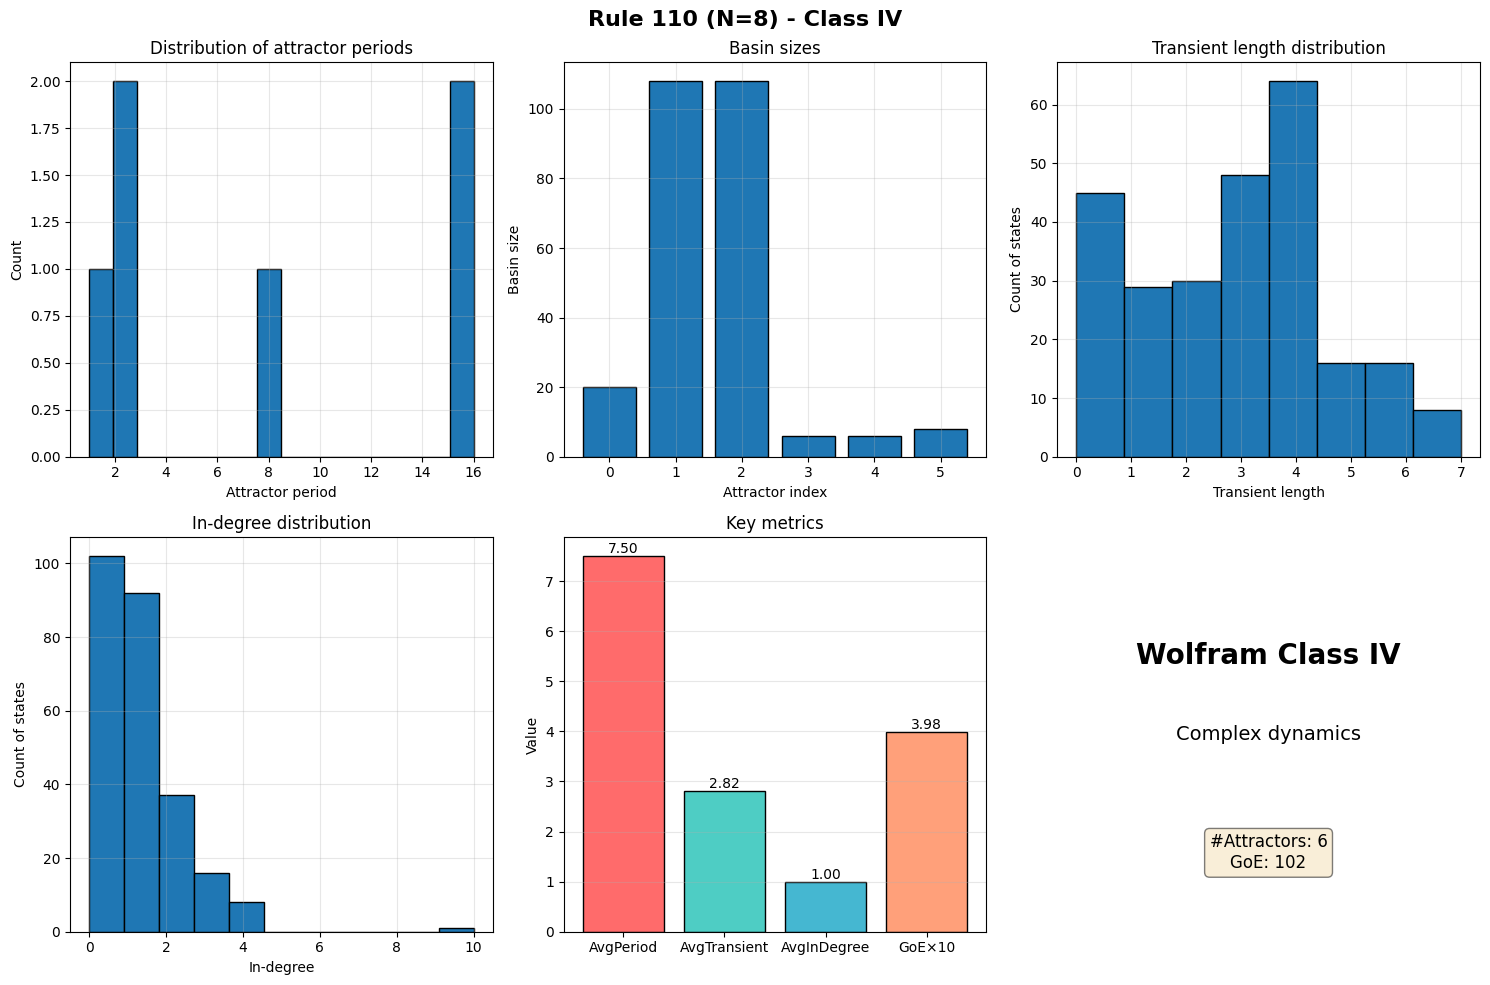

In [6]:
# ECA attractor-basin analysis system
# 说明：本版本“代码（标识符、打印文本等）全部英文”，仅注释为中文

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import json
import time
from typing import Dict, List, Tuple


class ECAAttractorAnalyzer:
    # ECA 吸引子盆分析器（标识符与输出均为英文；仅注释为中文）

    def __init__(self, rule: int, lattice_size: int):
        # 初始化：规则编号与晶格大小（N），并构建规则查找表
        self.rule = rule
        self.n = lattice_size
        self.total_states = 2 ** lattice_size
        self.lookup_table = self._rule_to_lookup(rule)

        # 容器：状态图、前驱表、吸引子列表、瞬态长度、状态-盆映射、盆大小
        self.graph: Dict[str, str] = {}
        self.predecessors: Dict[str, List[str]] = defaultdict(list)
        self.attractors: List[List[str]] = []
        self.transient_lengths: Dict[str, int] = {}
        self.state_to_basin: Dict[str, int] = {}
        self.basin_sizes: List[int] = []

    def _rule_to_lookup(self, rule_num: int) -> Dict[str, str]:
        # 将 Wolfram 规则号转为查找表（邻域使用 [111..000] 顺序）
        bits = format(rule_num, '08b')
        lut = {}
        for i in range(8):
            neighborhood = format(7 - i, '03b')  # 111,110,101,100,011,010,001,000
            lut[neighborhood] = bits[i]
        return lut

    def _apply_rule(self, state: str) -> str:
        # 应用规则（周期边界），从当前状态得到下一状态
        n = len(state)
        nxt = []
        for i in range(n):
            left = state[(i - 1) % n]
            center = state[i]
            right = state[(i + 1) % n]
            neighborhood = left + center + right
            nxt.append(self.lookup_table[neighborhood])
        return ''.join(nxt)

    def build_state_graph(self):
        # 构建完整状态转移图（遍历 2^N 个状态）
        print(f"Building state-transition graph... (total {self.total_states} states)")
        start = time.time()

        for i in range(self.total_states):
            s = format(i, f'0{self.n}b')
            t = self._apply_rule(s)
            self.graph[s] = t
            self.predecessors[t].append(s)

            if (i + 1) % 1000 == 0 or i == self.total_states - 1:
                pct = (i + 1) / self.total_states * 100
                print(f"  Progress: {i+1}/{self.total_states} ({pct:.1f}%)")

        elapsed = time.time() - start
        print(f"Graph built in {elapsed:.2f} s\n")

    def find_attractors(self):
        # 沿轨迹前行并检测环，识别全部吸引子
        print("Finding attractors...")
        visited = set()
        self.attractors = []

        for s in self.graph.keys():
            if s in visited:
                continue

            path: List[str] = []
            seen = set()
            cur = s

            while cur not in seen:
                if cur in visited:
                    break
                seen.add(cur)
                path.append(cur)
                cur = self.graph[cur]

            for u in path:
                visited.add(u)

            if cur in seen:
                idx = path.index(cur)
                cycle = path[idx:]
                self.attractors.append(cycle)

        print(f"Found {len(self.attractors)} attractor(s)")
        for i, cyc in enumerate(self.attractors):
            print(f"  Attractor #{i+1}: period = {len(cyc)}")
        print()

    def compute_transient_lengths(self):
        # 计算每个状态到达任一吸引子的步数（瞬态长度）
        print("Computing transient lengths...")

        attractor_states = set()
        for cyc in self.attractors:
            attractor_states.update(cyc)

        for s in self.graph.keys():
            cur = s
            length = 0
            local_visited = set()

            while cur not in attractor_states and cur not in local_visited:
                local_visited.add(cur)
                cur = self.graph[cur]
                length += 1

            self.transient_lengths[s] = length

        print("Transient lengths computed\n")

    def compute_basins(self):
        # 将每个状态分配到其吸引子盆，并统计各盆大小
        print("Computing basins...")

        for idx, cyc in enumerate(self.attractors):
            for s in cyc:
                self.state_to_basin[s] = idx

        for s in self.graph.keys():
            if s in self.state_to_basin:
                continue
            cur = s
            chain: List[str] = []
            while cur not in self.state_to_basin:
                chain.append(cur)
                cur = self.graph[cur]
            basin_idx = self.state_to_basin[cur]
            for u in chain:
                self.state_to_basin[u] = basin_idx

        self.basin_sizes = [0] * len(self.attractors)
        for b in self.state_to_basin.values():
            self.basin_sizes[b] += 1

        print("Basins computed")
        for i, size in enumerate(self.basin_sizes):
            pct = size / self.total_states * 100
            print(f"  Basin #{i+1}: {size} states ({pct:.1f}%)")
        print()

    def compute_statistics(self) -> Dict:
        # 汇总全局统计指标（吸引子数、周期、瞬态、入度分布、伊甸园密度等）
        print("Computing statistics...")

        num_attractors = len(self.attractors)
        attractor_periods = [len(a) for a in self.attractors]
        avg_period = float(np.mean(attractor_periods)) if attractor_periods else 0.0

        transient_vals = list(self.transient_lengths.values())
        max_transient = int(max(transient_vals)) if transient_vals else 0
        avg_transient = float(np.mean(transient_vals)) if transient_vals else 0.0

        indegrees = [len(self.predecessors[s]) for s in self.graph.keys()]
        avg_in_degree = float(np.mean(indegrees)) if indegrees else 0.0

        garden_of_eden_count = sum(1 for d in indegrees if d == 0)
        g_density = garden_of_eden_count / self.total_states if self.total_states > 0 else 0.0

        avg_basin_size = float(np.mean(self.basin_sizes)) if self.basin_sizes else 0.0

        stats = {
            "rule": self.rule,
            "lattice_size": self.n,
            "total_states": self.total_states,
            "num_attractors": num_attractors,
            "attractor_periods": attractor_periods,
            "avg_period": avg_period,
            "max_transient": max_transient,
            "avg_transient": avg_transient,
            "avg_in_degree": avg_in_degree,
            "g_density": g_density,
            "garden_of_eden_count": garden_of_eden_count,
            "basin_sizes": self.basin_sizes,
            "avg_basin_size": avg_basin_size,
        }

        print("Statistics computed\n")
        return stats

    def classify_rule(self, stats: Dict) -> Dict:
        # 基于经验阈值的粗分类（仅示例用途）
        avg_transient = stats["avg_transient"]
        avg_period = stats["avg_period"]
        avg_in_degree = stats["avg_in_degree"]
        g_density = stats["g_density"]

        if avg_transient < 2 and avg_period <= 2 and avg_in_degree > 1.5 and g_density > 0.3:
            return {
                "class": "I/II",
                "description": "Ordered dynamics",
                "characteristics": "Short transient, short period, high in-degree, high GoE density",
            }
        elif avg_transient > 10 and avg_period > 10 and avg_in_degree < 1.2 and g_density < 0.1:
            return {
                "class": "III",
                "description": "Chaotic dynamics",
                "characteristics": "Long transient, long period, low in-degree, low GoE density",
            }
        elif 2 <= avg_transient <= 10:
            return {
                "class": "IV",
                "description": "Complex dynamics",
                "characteristics": "Intermediate transient/period and balanced statistics",
            }
        else:
            return {
                "class": "II",
                "description": "Periodic dynamics",
                "characteristics": "Regular periodic behavior",
            }

    def analyze(self) -> Dict:
        # 完整流程：构图 → 吸引子 → 瞬态 → 盆 → 统计 → 分类
        print("=" * 60)
        print(f"Analyzing ECA Rule {self.rule}, lattice size N={self.n}")
        print("=" * 60)
        print()

        self.build_state_graph()
        self.find_attractors()
        self.compute_transient_lengths()
        self.compute_basins()
        stats = self.compute_statistics()
        classification = self.classify_rule(stats)

        results = {
            "statistics": stats,
            "classification": classification,
            "attractors_sample": [a[:10] for a in self.attractors[:5]],
        }

        print("=" * 60)
        print("Analysis complete!")
        print("=" * 60)

        return results

    def print_results(self, results: Dict):
        # 以可读格式打印主要结果
        stats = results["statistics"]
        classification = results["classification"]

        print("\n" + "=" * 60)
        print("Analysis Report")
        print("=" * 60)

        print("\n[Rule Info]")
        print(f"  Rule: {stats['rule']}")
        print(f"  Lattice size: {stats['lattice_size']}")
        print(f"  State space: 2^{stats['lattice_size']} = {stats['total_states']} states")

        print("\n[Wolfram-like Class]")
        print(f"  Class: {classification['class']}")
        print(f"  Description: {classification['description']}")
        print(f"  Characteristics: {classification['characteristics']}")

        print("\n[Key Statistics]")
        print(f"  # Attractors: {stats['num_attractors']}")
        print(f"  Avg. period: {stats['avg_period']:.2f}")
        print(f"  Max transient: {stats['max_transient']}")
        print(f"  Avg. transient: {stats['avg_transient']:.2f}")
        print(f"  Avg. in-degree: {stats['avg_in_degree']:.3f}")
        print(f"  Garden-of-Eden density: {stats['g_density']*100:.2f}%")
        print(f"  Garden-of-Eden count: {stats['garden_of_eden_count']}")
        print(f"  Avg. basin size: {stats['avg_basin_size']:.1f}")

        print("\n[Attractors]")
        for i, (period, bsize) in enumerate(zip(stats["attractor_periods"], stats["basin_sizes"])):
            pct = bsize / stats["total_states"] * 100
            print(f"  Attractor #{i+1}: period={period}, basin size={bsize} ({pct:.1f}%)")

        print("\n" + "=" * 60)

    def visualize_statistics(self, results: Dict):
        # 可视化：周期分布、盆大小、瞬态、入度、关键指标对比、文字面板
        stats = results["statistics"]
        classification = results["classification"]

        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle(
            f'Rule {stats["rule"]} (N={stats["lattice_size"]}) - Class {classification["class"]}',
            fontsize=16,
            fontweight="bold",
        )

        # (1) attractor period histogram
        ax = axes[0, 0]
        if stats["attractor_periods"]:
            ax.hist(
                stats["attractor_periods"],
                bins=min(20, max(stats["attractor_periods"])),
                edgecolor="black",
            )
        ax.set_xlabel("Attractor period")
        ax.set_ylabel("Count")
        ax.set_title("Distribution of attractor periods")
        ax.grid(True, alpha=0.3)

        # (2) basin size bar
        ax = axes[0, 1]
        if stats["basin_sizes"]:
            ax.bar(range(len(stats["basin_sizes"])), stats["basin_sizes"], edgecolor="black")
        ax.set_xlabel("Attractor index")
        ax.set_ylabel("Basin size")
        ax.set_title("Basin sizes")
        ax.grid(True, alpha=0.3)

        # (3) transient length histogram
        ax = axes[0, 2]
        tr_vals = list(self.transient_lengths.values())
        if tr_vals:
            ax.hist(tr_vals, bins=min(30, max(tr_vals) + 1), edgecolor="black")
        ax.set_xlabel("Transient length")
        ax.set_ylabel("Count of states")
        ax.set_title("Transient length distribution")
        ax.grid(True, alpha=0.3)

        # (4) in-degree histogram
        ax = axes[1, 0]
        indegrees = [len(self.predecessors[s]) for s in self.graph.keys()]
        if indegrees:
            ax.hist(indegrees, bins=min(20, max(indegrees) + 1), edgecolor="black")
        ax.set_xlabel("In-degree")
        ax.set_ylabel("Count of states")
        ax.set_title("In-degree distribution")
        ax.grid(True, alpha=0.3)

        # (5) key metrics bar
        ax = axes[1, 1]
        metric_names = ["AvgPeriod", "AvgTransient", "AvgInDegree", "GoE×10"]
        metric_vals = [
            stats["avg_period"],
            stats["avg_transient"],
            stats["avg_in_degree"],
            stats["g_density"] * 10,
        ]
        colors = ["#FF6B6B", "#4ECDC4", "#45B7D1", "#FFA07A"]
        bars = ax.bar(metric_names, metric_vals, color=colors, edgecolor="black")
        ax.set_ylabel("Value")
        ax.set_title("Key metrics")
        ax.grid(True, alpha=0.3, axis="y")
        for b, v in zip(bars, metric_vals):
            h = b.get_height()
            ax.text(b.get_x() + b.get_width() / 2.0, h, f"{v:.2f}", ha="center", va="bottom")

        # (6) class panel
        ax = axes[1, 2]
        ax.text(
            0.5,
            0.7,
            f"Wolfram Class {classification['class']}",
            ha="center",
            va="center",
            fontsize=20,
            fontweight="bold",
            transform=ax.transAxes,
        )
        ax.text(
            0.5,
            0.5,
            classification["description"],
            ha="center",
            va="center",
            fontsize=14,
            transform=ax.transAxes,
        )
        ax.text(
            0.5,
            0.2,
            f"#Attractors: {stats['num_attractors']}\nGoE: {stats['garden_of_eden_count']}",
            ha="center",
            va="center",
            fontsize=12,
            transform=ax.transAxes,
            bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
        )
        ax.axis("off")

        plt.tight_layout()
        plt.show()

    def save_results(self, results: Dict, filename: str = None):
        # 保存结果为 JSON（键名/值均英文）
        if filename is None:
            filename = f"eca_rule{self.rule}_n{self.n}_analysis.json"
        with open(filename, "w", encoding="utf-8") as f:
            json.dump(results, f, indent=2, ensure_ascii=False)
        print(f"\nResults saved to: {filename}")


# ------------------------ Helper: analyze one rule ------------------------

def analyze_single_rule(rule: int, lattice_size: int = 8, visualize: bool = True):
    # 分析单一规则（小 N 推荐），可选择可视化
    analyzer = ECAAttractorAnalyzer(rule, lattice_size)
    results = analyzer.analyze()
    analyzer.print_results(results)
    if visualize:
        analyzer.visualize_statistics(results)
    return results, analyzer


# ------------------------ Helper: batch analyze rules ------------------------

def batch_analyze_rules(rules: List[int], lattice_size: int = 8):
    # 批量分析多个规则（小 N 推荐），并打印汇总
    all_results = []

    for rule in rules:
        print(f"\n{'=' * 60}")
        print(f"Analyzing Rule {rule} ...")
        print(f"{'=' * 60}")

        analyzer = ECAAttractorAnalyzer(rule, lattice_size)
        results = analyzer.analyze()

        all_results.append(
            {
                "rule": rule,
                "class": results["classification"]["class"],
                "stats": results["statistics"],
            }
        )

    print("\n" + "=" * 80)
    print("Batch Summary")
    print("=" * 80)
    print(f"{'Rule':<8} {'Class':<10} {'#Attr':<10} {'AvgPeriod':<12} {'AvgTransient':<12} {'GoE%':<10}")
    print("-" * 80)

    for item in all_results:
        r = item["rule"]
        cls = item["class"]
        s = item["stats"]
        print(
            f"{r:<8} {cls:<10} {s['num_attractors']:<10} "
            f"{s['avg_period']:<12.2f} {s['avg_transient']:<12.2f} "
            f"{s['g_density']*100:<10.2f}"
        )

    return all_results


# ------------------------ Script entry (optional) ------------------------

if __name__ == "__main__":
    print("""
    ================================================
    ECA Attractor-Basin Analysis - Quick Start
    ================================================

    1) Analyze a single rule:
       results, analyzer = analyze_single_rule(rule=110, lattice_size=8)

    2) Batch analyze classic rules:
       rules = [30, 110, 54, 90, 150, 184, 254]
       batch_results = batch_analyze_rules(rules, lattice_size=8)

    3) Custom usage:
       analyzer = ECAAttractorAnalyzer(rule=110, lattice_size=8)
       results = analyzer.analyze()
       analyzer.print_results(results)
       analyzer.visualize_statistics(results)
       analyzer.save_results(results)

    Notes:
    - Prefer lattice_size <= 12 (state space 2^N).
    - N=8:   256 states (seconds)
    - N=10:  1024 states (~10-30s)
    - N=12:  4096 states (~1-3min)
    - N>12:  runtime grows quickly.
    """)

    print("\n[Example] Analyze Rule 110")
    results, analyzer = analyze_single_rule(rule=110, lattice_size=8, visualize=True)


Total unique rules to analyze: 88
Rules: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19, 22, 23]... (showing first 20)

STARTING COMPREHENSIVE ANALYSIS OF 88 UNIQUE ECA RULES
Lattice size: N=8 (256 states per rule)
Estimated total time: ~2-5 minutes


[1/88] Analyzing Rule 0...
Analyzing ECA Rule 0, lattice size N=8

Building state-transition graph... (total 256 states)
  Progress: 256/256 (100.0%)
Graph built in 0.00 s

Finding attractors...
Found 1 attractor(s)
  Attractor #1: period = 1

Computing transient lengths...
Transient lengths computed

Computing basins...
Basins computed
  Basin #1: 256 states (100.0%)

Computing statistics...
Statistics computed

Analysis complete!
  → Class II: Periodic dynamics
     Attractors=1, AvgPeriod=1.0, AvgTransient=1.0

[2/88] Analyzing Rule 1...
Analyzing ECA Rule 1, lattice size N=8

Building state-transition graph... (total 256 states)
  Progress: 256/256 (100.0%)
Graph built in 0.00 s

Finding attractors...
Found 23 attractor

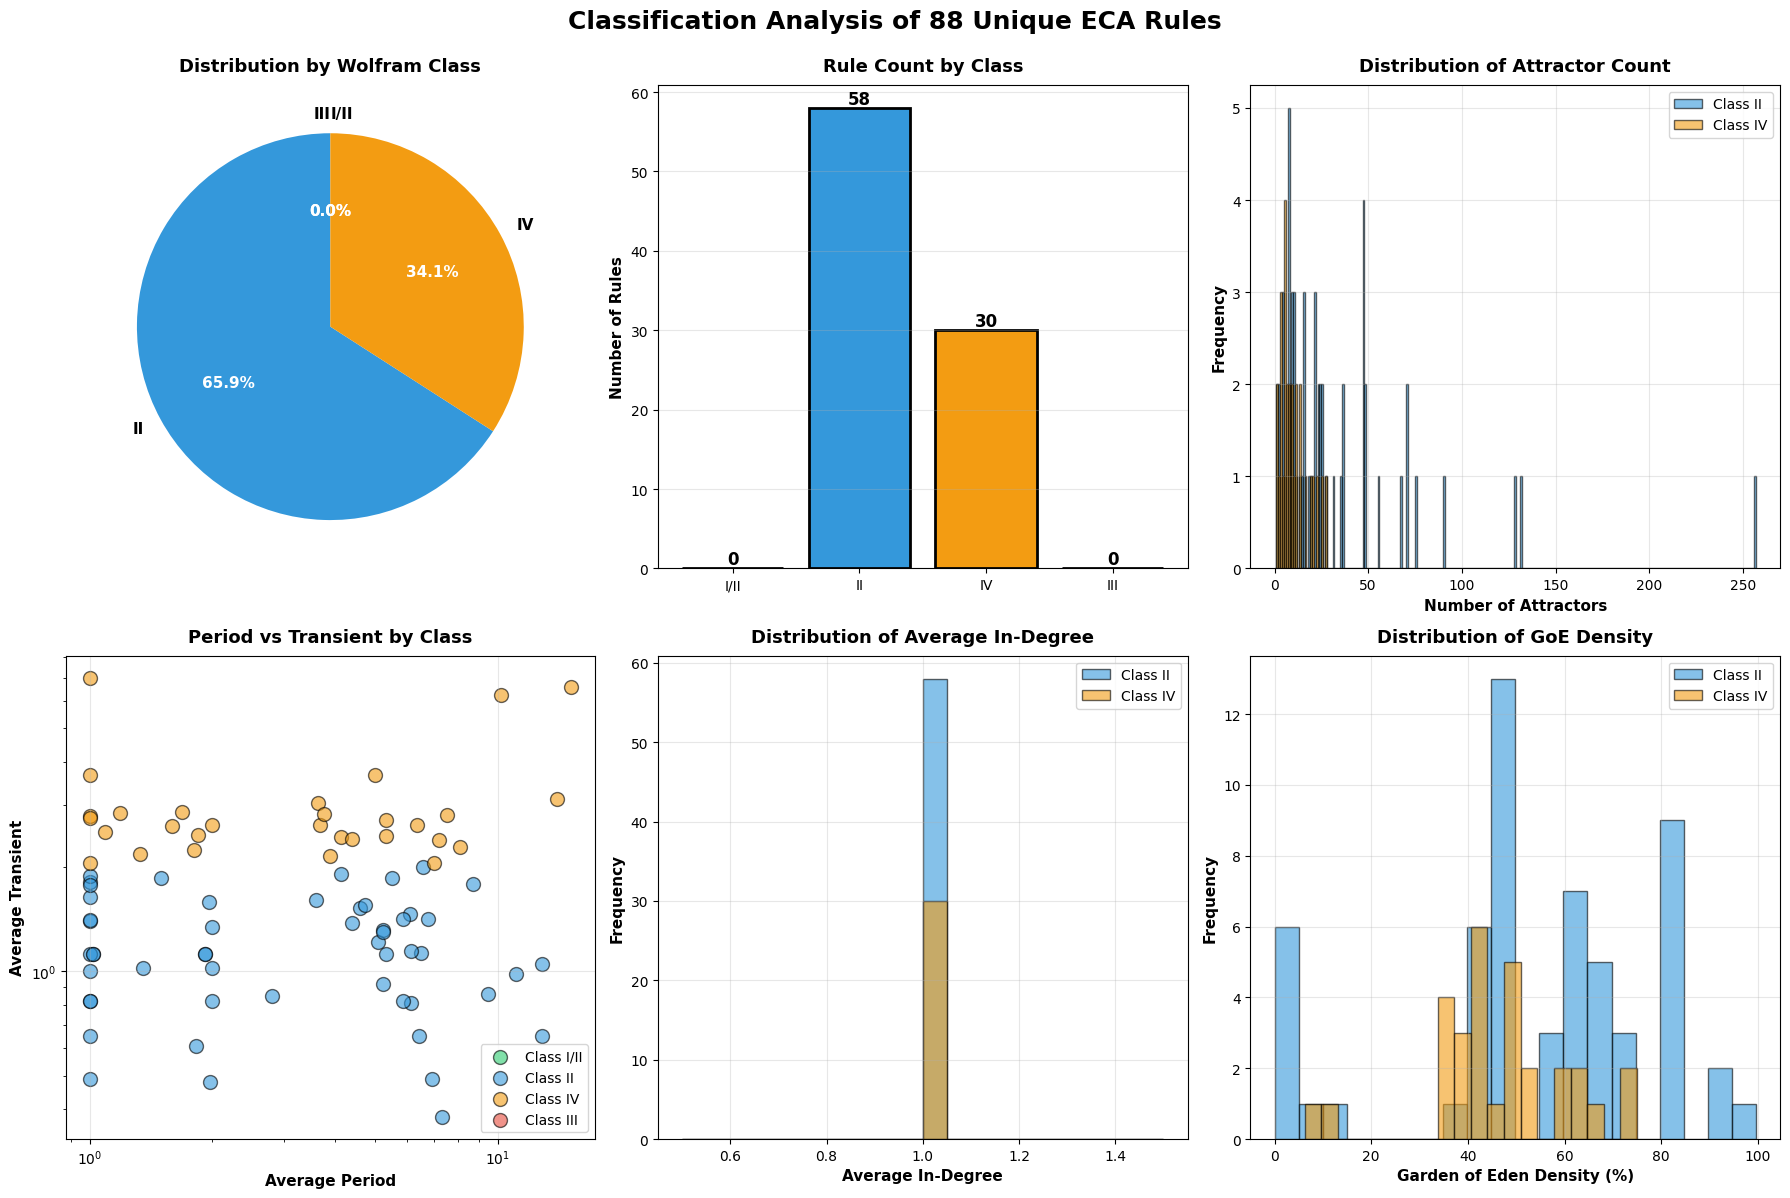

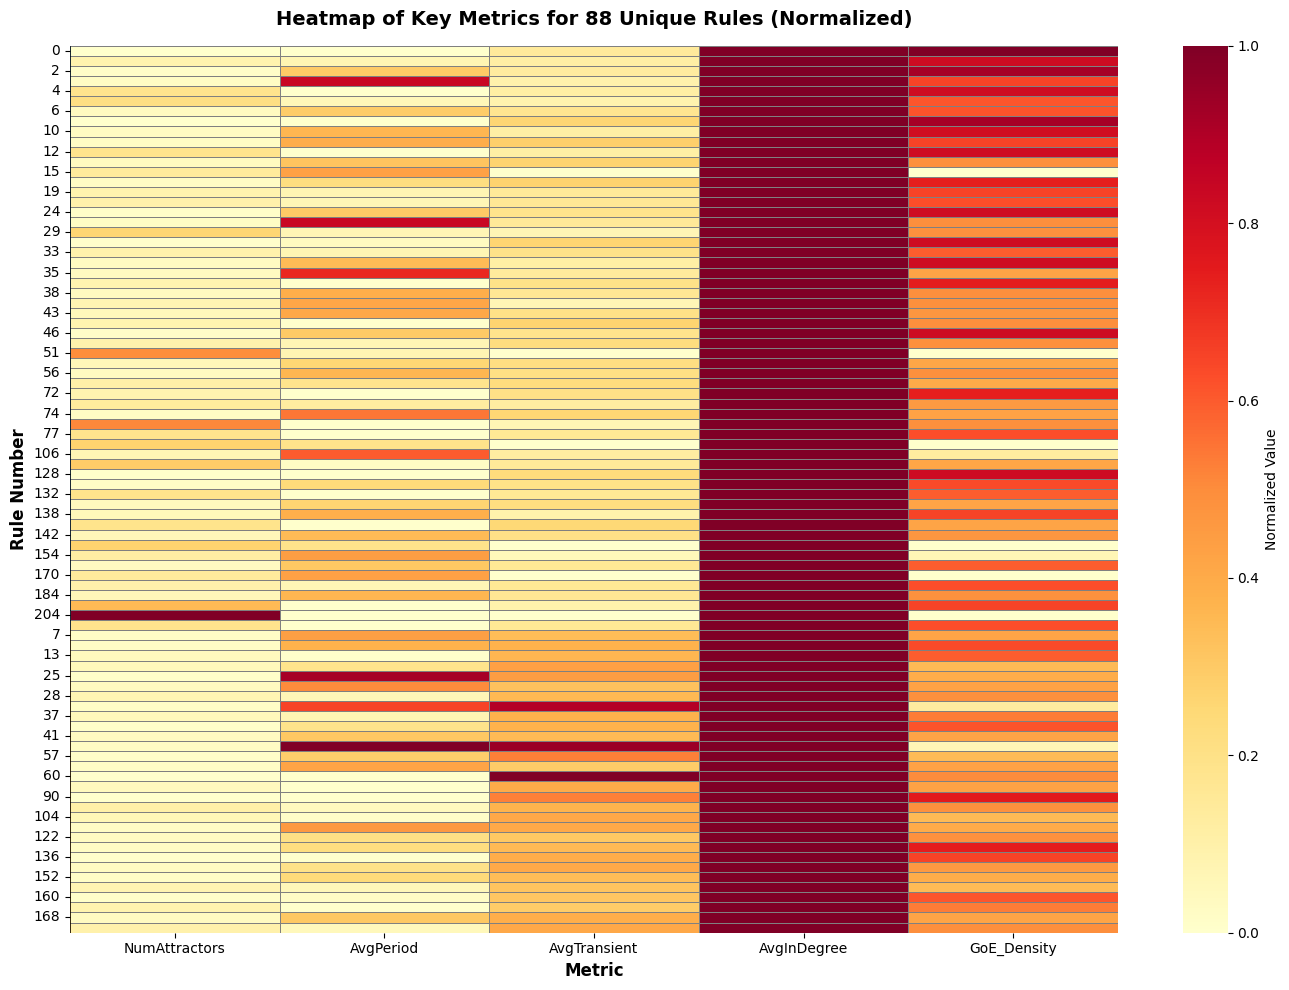


✓ Results saved to: eca_88_rules_classification.csv
✓ Results saved to: eca_88_rules_classification.json
✓ Summary saved to: eca_88_rules_summary.json

NOTABLE CLASSIC RULES

Rule  30 - Wolfram's famous chaotic rule
  → Class IV: Complex dynamics
     Attractors=5, Period=10.2, Transient=6.24

Rule 110 - Turing-complete complex rule
  → Class IV: Complex dynamics
     Attractors=6, Period=7.5, Transient=2.82

Rule  90 - Pascal's triangle / Sierpiński pattern
  → Class IV: Complex dynamics
     Attractors=1, Period=1.0, Transient=3.67

Rule  54 - Complex rule with intricate structure
  → Class II: Periodic dynamics
     Attractors=15, Period=4.6, Transient=1.52

Rule 184 - Traffic flow model
  → Class II: Periodic dynamics
     Attractors=15, Period=6.13, Transient=1.14

ANALYSIS COMPLETE - ALL RESULTS SAVED AND VISUALIZED


,Rule,Class,Description,NumAttractors,AvgPeriod,MaxTransient,AvgTransient,AvgInDegree,GoE_Density,GoE_Count,AvgBasinSize
0,0,II,Periodic dynamics,1,1.00,1,1.00,1.0,99.61,255,256.0
1,1,II,Periodic dynamics,23,2.00,1,0.82,1.0,82.03,210,11.1
2,2,II,Periodic dynamics,4,5.25,1,0.92,1.0,91.80,235,64.0
3,3,II,Periodic dynamics,7,12.86,1,0.65,1.0,64.84,166,36.6
4,4,II,Periodic dynamics,47,1.00,1,0.82,1.0,81.64,209,5.4
5,5,II,Periodic dynamics,55,1.82,1,0.61,1.0,60.94,156,4.7
6,6,II,Periodic dynamics,10,5.10,3,1.21,1.0,61.33,157,25.6
7,8,II,Periodic dynamics,1,1.00,2,1.81,1.0,91.80,235,256.0
8,10,II,Periodic dynamics,8,6.12,1,0.81,1.0,80.86,207,32.0
9,11,II,Periodic dynamics,7,6.57,4,1.99,1.0,64.84,166,36.6


In [8]:
"""
完整分析并分类88条独特的ECA规则
直接在Jupyter Notebook中运行此cell
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import seaborn as sns

# ============================================================================
# 88条独特的ECA规则（Wolfram的等价类代表）
# ============================================================================

# 这88条规则是256条规则在镜像、补色等对称性下的独特代表
UNIQUE_88_RULES = [
    0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
    18, 19, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36,
    37, 38, 40, 41, 42, 43, 44, 45, 46, 50, 51, 54, 56, 57, 58, 60,
    62, 72, 73, 74, 76, 77, 78, 90, 94, 104, 105, 106, 108, 110, 122,
    126, 128, 130, 132, 134, 136, 138, 140, 142, 146, 150, 152, 154, 156,
    160, 162, 164, 168, 170, 172, 178, 184, 200, 204, 232
]

print(f"Total unique rules to analyze: {len(UNIQUE_88_RULES)}")
print(f"Rules: {UNIQUE_88_RULES[:20]}... (showing first 20)\n")

# ============================================================================
# 批量分析所有88条规则
# ============================================================================

print("="*80)
print("STARTING COMPREHENSIVE ANALYSIS OF 88 UNIQUE ECA RULES")
print("="*80)
print(f"Lattice size: N=8 (256 states per rule)")
print(f"Estimated total time: ~2-5 minutes\n")

# 存储所有结果
all_results = []
classification_summary = []

# 分析每条规则
for idx, rule in enumerate(UNIQUE_88_RULES, 1):
    print(f"\n[{idx}/88] Analyzing Rule {rule}...")
    
    try:
        # 创建分析器并运行
        analyzer = ECAAttractorAnalyzer(rule=rule, lattice_size=8)
        results = analyzer.analyze()
        
        # 提取关键信息
        stats = results["statistics"]
        classification = results["classification"]
        
        # 保存结果
        result_entry = {
            'Rule': rule,
            'Class': classification['class'],
            'Description': classification['description'],
            'NumAttractors': stats['num_attractors'],
            'AvgPeriod': round(stats['avg_period'], 2),
            'MaxTransient': stats['max_transient'],
            'AvgTransient': round(stats['avg_transient'], 2),
            'AvgInDegree': round(stats['avg_in_degree'], 3),
            'GoE_Density': round(stats['g_density'] * 100, 2),
            'GoE_Count': stats['garden_of_eden_count'],
            'AvgBasinSize': round(stats['avg_basin_size'], 1)
        }
        
        all_results.append(result_entry)
        classification_summary.append(classification['class'])
        
        # 简要输出
        print(f"  → Class {classification['class']}: {classification['description']}")
        print(f"     Attractors={stats['num_attractors']}, "
              f"AvgPeriod={stats['avg_period']:.1f}, "
              f"AvgTransient={stats['avg_transient']:.1f}")
        
    except Exception as e:
        print(f"  ✗ Error analyzing Rule {rule}: {e}")
        # 记录失败的规则
        all_results.append({
            'Rule': rule,
            'Class': 'ERROR',
            'Description': str(e),
            'NumAttractors': 0,
            'AvgPeriod': 0,
            'MaxTransient': 0,
            'AvgTransient': 0,
            'AvgInDegree': 0,
            'GoE_Density': 0,
            'GoE_Count': 0,
            'AvgBasinSize': 0
        })

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)

# ============================================================================
# 创建结果DataFrame
# ============================================================================

df_results = pd.DataFrame(all_results)

# 按类别排序
class_order = {'I/II': 1, 'II': 2, 'IV': 3, 'III': 4, 'ERROR': 5}
df_results['ClassOrder'] = df_results['Class'].map(class_order)
df_results = df_results.sort_values(['ClassOrder', 'Rule']).drop('ClassOrder', axis=1)
df_results = df_results.reset_index(drop=True)

# ============================================================================
# 分类统计
# ============================================================================

print("\n" + "="*80)
print("CLASSIFICATION SUMMARY")
print("="*80)

class_counts = Counter(classification_summary)
total = len(classification_summary)

print(f"\nTotal rules analyzed: {total}")
print(f"\nBreakdown by Wolfram Class:")
print("-" * 50)

for cls in ['I/II', 'II', 'IV', 'III']:
    count = class_counts.get(cls, 0)
    percentage = (count / total * 100) if total > 0 else 0
    print(f"  Class {cls:4s}: {count:3d} rules ({percentage:5.1f}%)")

# 列出每个类别的规则
print("\n" + "="*80)
print("RULES BY CLASS")
print("="*80)

for cls in ['I/II', 'II', 'IV', 'III']:
    rules_in_class = df_results[df_results['Class'] == cls]['Rule'].tolist()
    if rules_in_class:
        print(f"\nClass {cls} ({len(rules_in_class)} rules):")
        print(f"  {rules_in_class}")

# ============================================================================
# 详细结果表格
# ============================================================================

print("\n" + "="*80)
print("DETAILED RESULTS TABLE")
print("="*80)
print()

# 设置pandas显示选项
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print(df_results.to_string(index=False))

# ============================================================================
# 可视化：分类分布
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Classification Analysis of 88 Unique ECA Rules', 
             fontsize=18, fontweight='bold', y=0.995)

# 1. 饼图：分类占比
ax = axes[0, 0]
class_colors = {'I/II': '#2ecc71', 'II': '#3498db', 'IV': '#f39c12', 'III': '#e74c3c'}
classes = ['I/II', 'II', 'IV', 'III']
sizes = [class_counts.get(cls, 0) for cls in classes]
colors = [class_colors[cls] for cls in classes]

wedges, texts, autotexts = ax.pie(sizes, labels=classes, colors=colors, autopct='%1.1f%%',
                                    startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
for autotext in autotexts:
    autotext.set_color('white')
ax.set_title('Distribution by Wolfram Class', fontsize=13, fontweight='bold', pad=10)

# 2. 柱状图：每个类别的规则数量
ax = axes[0, 1]
bars = ax.bar(classes, sizes, color=colors, edgecolor='black', linewidth=2)
ax.set_ylabel('Number of Rules', fontsize=11, fontweight='bold')
ax.set_title('Rule Count by Class', fontsize=13, fontweight='bold', pad=10)
ax.grid(True, alpha=0.3, axis='y')
for bar, size in zip(bars, sizes):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(size)}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# 3. 吸引子数量分布
ax = axes[0, 2]
for cls in classes:
    data = df_results[df_results['Class'] == cls]['NumAttractors']
    if len(data) > 0:
        ax.hist(data, bins=range(0, int(data.max())+2), alpha=0.6, 
               label=f'Class {cls}', color=class_colors[cls], edgecolor='black')
ax.set_xlabel('Number of Attractors', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title('Distribution of Attractor Count', fontsize=13, fontweight='bold', pad=10)
ax.legend()
ax.grid(True, alpha=0.3)

# 4. 平均周期 vs 平均瞬态（散点图）
ax = axes[1, 0]
for cls in classes:
    data = df_results[df_results['Class'] == cls]
    ax.scatter(data['AvgPeriod'], data['AvgTransient'], 
              label=f'Class {cls}', color=class_colors[cls], 
              s=100, alpha=0.6, edgecolor='black', linewidth=1)
ax.set_xlabel('Average Period', fontsize=11, fontweight='bold')
ax.set_ylabel('Average Transient', fontsize=11, fontweight='bold')
ax.set_title('Period vs Transient by Class', fontsize=13, fontweight='bold', pad=10)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xscale('log')
ax.set_yscale('log')

# 5. 平均入度分布
ax = axes[1, 1]
for cls in classes:
    data = df_results[df_results['Class'] == cls]['AvgInDegree']
    if len(data) > 0:
        ax.hist(data, bins=20, alpha=0.6, label=f'Class {cls}',
               color=class_colors[cls], edgecolor='black')
ax.set_xlabel('Average In-Degree', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title('Distribution of Average In-Degree', fontsize=13, fontweight='bold', pad=10)
ax.legend()
ax.grid(True, alpha=0.3)

# 6. 伊甸园密度分布
ax = axes[1, 2]
for cls in classes:
    data = df_results[df_results['Class'] == cls]['GoE_Density']
    if len(data) > 0:
        ax.hist(data, bins=20, alpha=0.6, label=f'Class {cls}',
               color=class_colors[cls], edgecolor='black')
ax.set_xlabel('Garden of Eden Density (%)', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title('Distribution of GoE Density', fontsize=13, fontweight='bold', pad=10)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# 热图：关键指标对比
# ============================================================================

fig, ax = plt.subplots(figsize=(14, 10))

# 选择关键指标进行可视化
metrics = ['NumAttractors', 'AvgPeriod', 'AvgTransient', 'AvgInDegree', 'GoE_Density']
df_heatmap = df_results[['Rule', 'Class'] + metrics].set_index('Rule')

# 标准化数据（每列归一化到0-1）
df_normalized = df_heatmap[metrics].copy()
for col in metrics:
    min_val = df_normalized[col].min()
    max_val = df_normalized[col].max()
    if max_val > min_val:
        df_normalized[col] = (df_normalized[col] - min_val) / (max_val - min_val)

# 绘制热图
sns.heatmap(df_normalized, cmap='YlOrRd', cbar_kws={'label': 'Normalized Value'},
            linewidths=0.5, linecolor='gray', ax=ax)

ax.set_title('Heatmap of Key Metrics for 88 Unique Rules (Normalized)', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Metric', fontsize=12, fontweight='bold')
ax.set_ylabel('Rule Number', fontsize=12, fontweight='bold')

# 添加类别颜色条
for idx, (rule, cls) in enumerate(zip(df_heatmap.index, df_heatmap['Class'])):
    color = class_colors.get(cls, 'gray')
    ax.add_patch(plt.Rectangle((-0.5, idx), 0.5, 1, 
                               facecolor=color, edgecolor='black', linewidth=0.5))

plt.tight_layout()
plt.show()

# ============================================================================
# 保存结果
# ============================================================================

# 保存为CSV
csv_filename = 'eca_88_rules_classification.csv'
df_results.to_csv(csv_filename, index=False)
print(f"\n✓ Results saved to: {csv_filename}")

# 保存为JSON
json_filename = 'eca_88_rules_classification.json'
df_results.to_json(json_filename, orient='records', indent=2)
print(f"✓ Results saved to: {json_filename}")

# 保存分类汇总
summary_dict = {
    'total_rules': total,
    'classification_counts': dict(class_counts),
    'rules_by_class': {
        cls: df_results[df_results['Class'] == cls]['Rule'].tolist()
        for cls in ['I/II', 'II', 'IV', 'III']
    }
}

summary_filename = 'eca_88_rules_summary.json'
import json
with open(summary_filename, 'w') as f:
    json.dump(summary_dict, f, indent=2)
print(f"✓ Summary saved to: {summary_filename}")

# ============================================================================
# 经典规则的特别标注
# ============================================================================

print("\n" + "="*80)
print("NOTABLE CLASSIC RULES")
print("="*80)

classic_rules = {
    30: "Wolfram's famous chaotic rule",
    110: "Turing-complete complex rule",
    90: "Pascal's triangle / Sierpiński pattern",
    54: "Complex rule with intricate structure",
    184: "Traffic flow model",
    254: "Simple fixed-point behavior"
}

print()
for rule, description in classic_rules.items():
    if rule in df_results['Rule'].values:
        row = df_results[df_results['Rule'] == rule].iloc[0]
        print(f"Rule {rule:3d} - {description}")
        print(f"  → Class {row['Class']}: {row['Description']}")
        print(f"     Attractors={row['NumAttractors']}, "
              f"Period={row['AvgPeriod']}, "
              f"Transient={row['AvgTransient']}")
        print()

print("="*80)
print("ANALYSIS COMPLETE - ALL RESULTS SAVED AND VISUALIZED")
print("="*80)

# 返回DataFrame供后续使用
df_results


ECA Lyapunov Analysis - Quick Guide (EN outputs)

1) Single rule (with visualization):
   results, analyzer = analyze_single_rule_lyapunov(
       rule=110,
       lattice_size=100,
       max_time=500,
       num_trials=20
   )

2) Batch analysis:
   rules = [30, 110, 54, 90, 150, 184, 254]
   batch = batch_analyze_rules_lyapunov(
       rules,
       lattice_size=100,
       max_time=300,
       num_trials=10
   )

3) Custom:
   analyzer = ECALyapunovAnalyzer(rule=110, lattice_size=100)
   results = analyzer.full_analysis(max_time=500, num_trials=20)
   analyzer.print_results(results)
   analyzer.visualize_results(results)
   analyzer.visualize_spacetime_with_damage()


[Example] Analyze Rule 110
Lyapunov analysis: ECA Rule 110, lattice size N=100

[Step 1/3] Damage-spreading curve
Running damage-spreading analysis... (rule 110, trials=15)
  Trial 3/15 completed
  Trial 6/15 completed
  Trial 9/15 completed
  Trial 12/15 completed
  Trial 15/15 completed

[Step 2/3] Maximum Lyapunov

/var/tmp/pbs.2146.cbis-pbs/ipykernel_3589822/3063740006.py:390: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


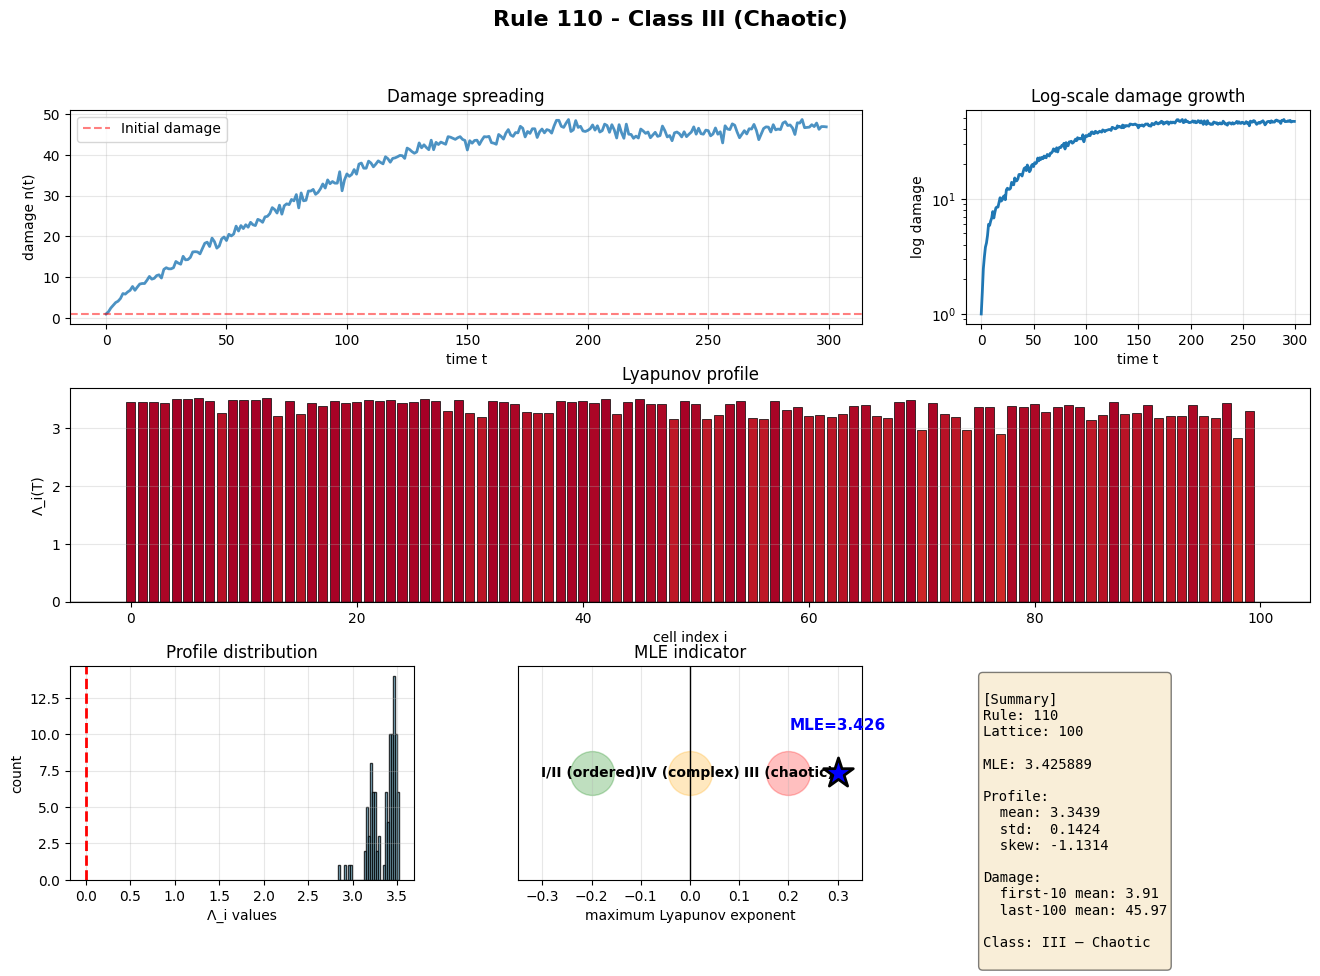

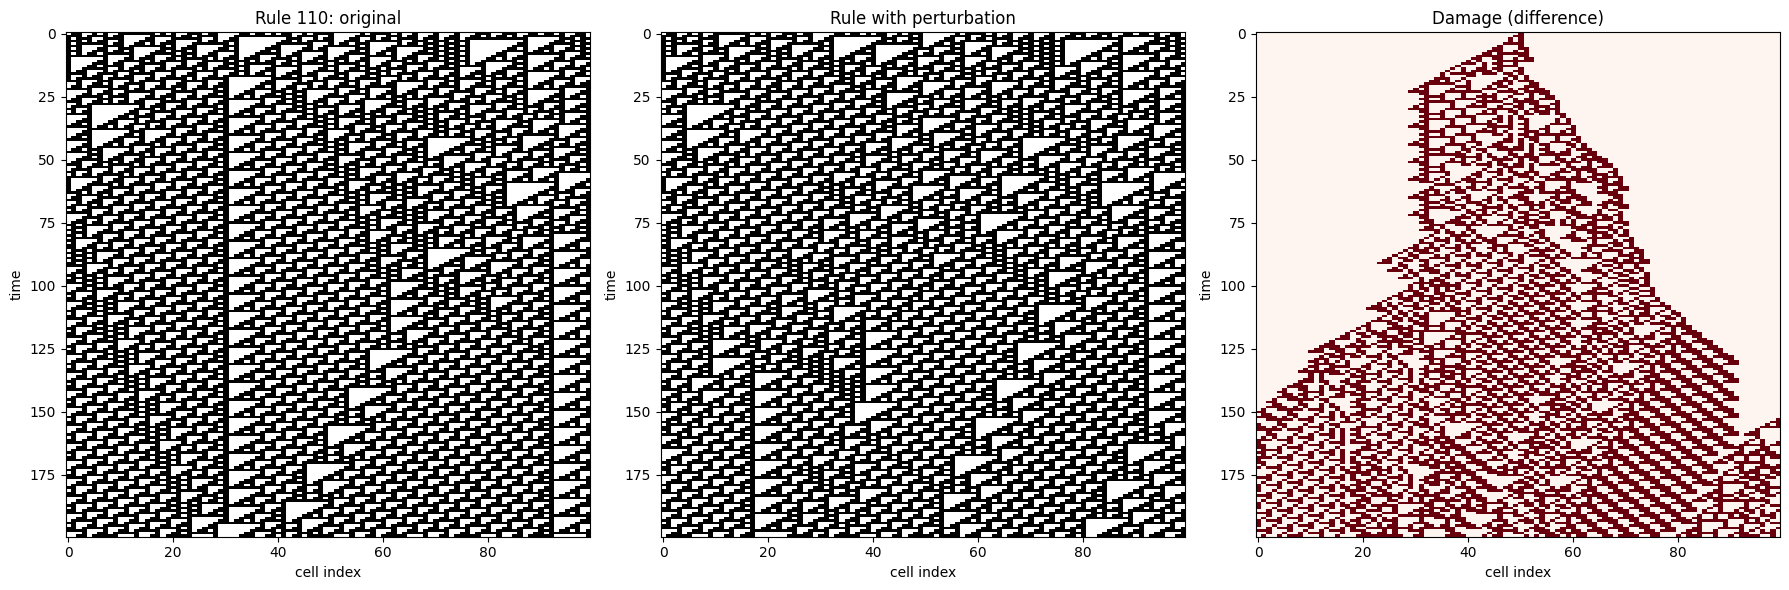

In [7]:
"""
ECA Lyapunov Exponent & Profile Analysis System
- All code (identifiers, printed text, plot labels) is in ENGLISH.
- Only the COMMENTS are in Chinese for explanation.
"""

import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
import time


class ECALyapunovAnalyzer:
    """
    Lyapunov analysis toolkit for Elementary Cellular Automata (ECA).
    """

    def __init__(self, rule: int, lattice_size: int = 100):
        # 初始化：记录规则编号与晶格长度，预构建规则查找表（Wolfram 编码）
        self.rule = rule
        self.n = lattice_size
        self.lookup_table = self._rule_to_lookup(rule)

        # 结果容器：Lyapunov 指标与分类
        self.lyapunov_exponents: List[float] = []
        self.lambda_profile: np.ndarray | None = None
        self.classification: Dict | None = None

    def _rule_to_lookup(self, rule_num: int) -> Dict[str, int]:
        # 将规则编号映射为查找表，邻域按 Wolfram 顺序 [111..000]
        bits = format(rule_num, "08b")
        lut: Dict[str, int] = {}
        for i in range(8):
            neighborhood = format(7 - i, "03b")  # 111,110,101,100,011,010,001,000
            lut[neighborhood] = int(bits[i])
        return lut

    def _apply_rule(self, state: np.ndarray) -> np.ndarray:
        # 周期边界条件下的一步演化
        n = len(state)
        new_state = np.zeros(n, dtype=int)
        for i in range(n):
            left = state[(i - 1) % n]
            center = state[i]
            right = state[(i + 1) % n]
            neighborhood = f"{left}{center}{right}"
            new_state[i] = self.lookup_table[neighborhood]
        return new_state

    def compute_damage(self, state1: np.ndarray, state2: np.ndarray) -> int:
        # 计算两条轨道在同一时刻的汉明距离（缺陷总数）
        return int(np.sum(state1 != state2))

    def compute_jacobian_matrix(self, state: np.ndarray) -> np.ndarray:
        # 计算布尔雅可比矩阵 J(s(t))；J[i,j]=1 表示 j 处扰动会影响到 i 的下一时刻
        n = len(state)
        J = np.zeros((n, n), dtype=int)

        base_next = self._apply_rule(state)
        for j in range(n):
            perturbed = state.copy()
            perturbed[j] ^= 1  # 翻转 j 位置
            next_perturbed = self._apply_rule(perturbed)
            J[:, j] = (base_next != next_perturbed).astype(int)
        return J

    def damage_spreading_analysis(
        self,
        initial_damage: int = 1,
        max_time: int = 500,
        num_trials: int = 20,
        seed: int | None = None,
    ) -> Tuple[np.ndarray, np.ndarray]:
        # 统计“缺陷随时间扩散”的平均曲线：从随机初态、引入有限个扰动位，跟踪 n(t)
        print(f"Running damage-spreading analysis... (rule {self.rule}, trials={num_trials})")

        rng = np.random.default_rng(seed)
        damage_history = np.zeros((num_trials, max_time), dtype=float)

        for trial in range(num_trials):
            s1 = rng.integers(0, 2, self.n, dtype=int)
            s2 = s1.copy()

            idx = rng.choice(self.n, initial_damage, replace=False)
            s2[idx] ^= 1

            for t in range(max_time):
                damage_history[trial, t] = self.compute_damage(s1, s2)
                s1 = self._apply_rule(s1)
                s2 = self._apply_rule(s2)

            if (trial + 1) % max(1, num_trials // 4) == 0:
                print(f"  Trial {trial + 1}/{num_trials} completed")

        time_steps = np.arange(max_time)
        avg_damage = damage_history.mean(axis=0)
        return time_steps, avg_damage

    def compute_mle(
        self,
        max_time: int = 500,
        num_trials: int = 20,
        epsilon: float = 1e-10,
        seed: int | None = None,
    ) -> float:
        # 计算最大 Lyapunov 指数（以对数缺陷增长的时间平均近似）
        print(f"Estimating MLE... (rule {self.rule})")

        rng = np.random.default_rng(seed)
        mle_sum = 0.0
        valid_trials = 0

        for trial in range(num_trials):
            s1 = rng.integers(0, 2, self.n, dtype=int)
            s2 = s1.copy()
            pos = rng.integers(0, self.n)
            s2[pos] ^= 1

            log_sum = 0.0
            for _ in range(max_time):
                damage = self.compute_damage(s1, s2)
                if damage > 0:
                    log_sum += np.log(damage + epsilon)
                s1 = self._apply_rule(s1)
                s2 = self._apply_rule(s2)

            if log_sum != 0.0:
                mle_sum += log_sum / max_time
                valid_trials += 1

        mle = mle_sum / valid_trials if valid_trials > 0 else 0.0
        print(f"  MLE = {mle:.6f}")
        return float(mle)

    def compute_lyapunov_profile(
        self,
        max_time: int = 500,
        num_trials: int = 20,
        seed: int | None = None,
    ) -> np.ndarray:
        # 计算 Lyapunov “剖面” Λ_i：对每个位置引入单点扰动，累积 log(缺陷)
        print(f"Computing Lyapunov profile... (rule {self.rule})")

        rng = np.random.default_rng(seed)
        profile = np.zeros(self.n, dtype=float)

        for trial in range(num_trials):
            base = rng.integers(0, 2, self.n, dtype=int)

            growth = np.zeros(self.n, dtype=float)
            for i in range(self.n):
                s1 = base.copy()
                s2 = base.copy()
                s2[i] ^= 1

                acc = 0.0
                for _ in range(max_time):
                    d = self.compute_damage(s1, s2)
                    if d > 0:
                        acc += np.log(d + 1e-10)
                    s1 = self._apply_rule(s1)
                    s2 = self._apply_rule(s2)
                growth[i] = acc / max_time

            profile += growth

            if (trial + 1) % max(1, num_trials // 4) == 0:
                print(f"  Trial {trial + 1}/{num_trials} completed")

        profile /= num_trials
        self.lambda_profile = profile
        return profile

    def classify_by_lyapunov(self, mle: float, profile: np.ndarray | None = None) -> Dict:
        # 基于 MLE 与剖面统计的粗分类（经验阈值，用于教学与快速探索）
        if mle < -0.1:
            wolfram_class = "I/II"
            description = "Ordered"
            characteristics = "Negative MLE; damage decays."
        elif mle > 0.1:
            wolfram_class = "III"
            description = "Chaotic"
            characteristics = "Positive MLE; exponential damage growth."
        else:
            wolfram_class = "IV"
            description = "Complex"
            characteristics = "MLE near zero; critical/edge-of-chaos behavior."

        if profile is not None:
            std = float(np.std(profile))
            skew = float(np.mean((profile - np.mean(profile)) ** 3) / (std**3 + 1e-10))
            # Class IV 常伴随非对称或分段特征；若偏度显著且 |MLE| 小，则倾向 IV
            if abs(skew) > 0.5 and abs(mle) < 0.2:
                wolfram_class = "IV"
                description = "Complex"
                characteristics += f" (profile skewness={skew:.2f})"

        return {
            "class": wolfram_class,
            "description": description,
            "characteristics": characteristics,
            "mle": float(mle),
        }

    def full_analysis(self, max_time: int = 500, num_trials: int = 20, seed: int | None = None) -> Dict:
        # 完整流程：缺陷扩散 → MLE → 剖面 → 分类
        print("=" * 70)
        print(f"Lyapunov analysis: ECA Rule {self.rule}, lattice size N={self.n}")
        print("=" * 70)
        print()

        print("[Step 1/3] Damage-spreading curve")
        t, avg_damage = self.damage_spreading_analysis(
            initial_damage=1, max_time=max_time, num_trials=num_trials, seed=seed
        )
        print()

        print("[Step 2/3] Maximum Lyapunov exponent (MLE)")
        mle = self.compute_mle(max_time=max_time, num_trials=num_trials, seed=seed)
        print()

        print("[Step 3/3] Lyapunov spatial profile")
        profile = self.compute_lyapunov_profile(max_time=max_time, num_trials=num_trials, seed=seed)
        print()

        cls = self.classify_by_lyapunov(mle, profile)

        results = {
            "rule": self.rule,
            "lattice_size": self.n,
            "mle": float(mle),
            "lyapunov_profile": profile,
            "damage_time": t,
            "damage_spread": avg_damage,
            "classification": cls,
        }

        print("=" * 70)
        print("Analysis done.")
        print("=" * 70)
        return results

    def print_results(self, results: Dict):
        # 打印整洁的指标汇总
        print("\n" + "=" * 70)
        print("Lyapunov Analysis Report")
        print("=" * 70)

        print("\n[Rule Info]")
        print(f"  Rule: {results['rule']}")
        print(f"  Lattice size: {results['lattice_size']}")

        print("\n[Wolfram-like Class]")
        c = results["classification"]
        print(f"  Class: {c['class']}")
        print(f"  Description: {c['description']}")
        print(f"  Characteristics: {c['characteristics']}")

        print("\n[Lyapunov Metrics]")
        print(f"  MLE: {results['mle']:.6f}")
        profile = results["lyapunov_profile"]
        print("  Profile stats:")
        print(f"    - Mean: {np.mean(profile):.6f}")
        print(f"    - Std:  {np.std(profile):.6f}")
        print(f"    - Min:  {np.min(profile):.6f}")
        print(f"    - Max:  {np.max(profile):.6f}")

        dmg = results["damage_spread"]
        init_dmg = float(np.mean(dmg[: min(10, len(dmg))]))
        tail_slice = dmg[-min(100, len(dmg)) :]
        final_dmg = float(np.mean(tail_slice))
        growth = (final_dmg / (init_dmg + 1e-12)) if init_dmg > 0 else np.inf

        print("\n[Damage Spreading]")
        print(f"  Initial (first 10): {init_dmg:.2f}")
        print(f"  Final (last 100):  {final_dmg:.2f}")
        print(f"  Growth factor:     {growth:.2f}x")

        print("\n" + "=" * 70)

    def visualize_results(self, results: Dict):
        # 可视化：缺陷扩散曲线、对数尺度、剖面条形图、剖面直方图、MLE 指示器与摘要
        fig = plt.figure(figsize=(16, 10))
        gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

        c = results["classification"]
        fig.suptitle(
            f'Rule {results["rule"]} - Class {c["class"]} ({c["description"]})',
            fontsize=16,
            fontweight="bold",
        )

        # (1) Damage-spreading curve
        ax1 = fig.add_subplot(gs[0, :2])
        t = results["damage_time"]
        dmg = results["damage_spread"]
        ax1.plot(t, dmg, "-", linewidth=2, alpha=0.8)
        ax1.axhline(y=1, color="r", linestyle="--", alpha=0.5, label="Initial damage")
        ax1.set_xlabel("time t")
        ax1.set_ylabel("damage n(t)")
        ax1.set_title("Damage spreading")
        ax1.grid(True, alpha=0.3)
        ax1.legend()

        # (2) Log damage
        ax2 = fig.add_subplot(gs[0, 2])
        dmg_nz = np.maximum(dmg, 1e-10)
        ax2.semilogy(t, dmg_nz, "-", linewidth=2)
        ax2.set_xlabel("time t")
        ax2.set_ylabel("log damage")
        ax2.set_title("Log-scale damage growth")
        ax2.grid(True, alpha=0.3)

        # (3) Lyapunov profile (bar)
        ax3 = fig.add_subplot(gs[1, :])
        prof = results["lyapunov_profile"]
        x = np.arange(len(prof))
        # 颜色按归一化后的剖面值着色
        denom = np.max(np.abs(prof)) + 1e-10
        colors = plt.cm.RdYlBu_r(prof / denom * 0.5 + 0.5)
        ax3.bar(x, prof, color=colors, edgecolor="black", linewidth=0.5)
        ax3.axhline(y=0, color="black", linestyle="-", linewidth=1)
        ax3.set_xlabel("cell index i")
        ax3.set_ylabel("Λ_i(T)")
        ax3.set_title("Lyapunov profile")
        ax3.grid(True, alpha=0.3, axis="y")

        # (4) Profile histogram
        ax4 = fig.add_subplot(gs[2, 0])
        ax4.hist(prof, bins=30, color="skyblue", edgecolor="black", alpha=0.8)
        ax4.axvline(x=0, color="red", linestyle="--", linewidth=2)
        ax4.set_xlabel("Λ_i values")
        ax4.set_ylabel("count")
        ax4.set_title("Profile distribution")
        ax4.grid(True, alpha=0.3)

        # (5) MLE indicator
        ax5 = fig.add_subplot(gs[2, 1])
        mle = results["mle"]
        labels = ["I/II (ordered)", "IV (complex)", "III (chaotic)"]
        centers = [-0.2, 0.0, 0.2]
        cols = ["green", "orange", "red"]
        for lbl, cx, col in zip(labels, centers, cols):
            ax5.scatter(cx, 0.5, s=1000, alpha=0.25, color=col)
            ax5.text(cx, 0.5, lbl, ha="center", va="center", fontsize=10, fontweight="bold")
        x_mle = float(np.clip(mle, -0.3, 0.3))
        ax5.scatter(x_mle, 0.5, s=500, color="blue", marker="*", edgecolor="black", linewidth=2, zorder=10)
        ax5.text(x_mle, 0.7, f"MLE={mle:.3f}", ha="center", fontsize=11, fontweight="bold", color="blue")
        ax5.set_xlim(-0.35, 0.35)
        ax5.set_ylim(0, 1)
        ax5.set_xlabel("maximum Lyapunov exponent")
        ax5.set_title("MLE indicator")
        ax5.set_yticks([])
        ax5.axvline(x=0, color="black", linestyle="-", linewidth=1)
        ax5.grid(True, alpha=0.3, axis="x")

        # (6) Summary panel
        ax6 = fig.add_subplot(gs[2, 2])
        ax6.axis("off")
        skew = float(np.mean((prof - np.mean(prof)) ** 3) / (np.std(prof) ** 3 + 1e-10))
        summary = f"""
[Summary]
Rule: {results['rule']}
Lattice: {results['lattice_size']}

MLE: {mle:.6f}

Profile:
  mean: {np.mean(prof):.4f}
  std:  {np.std(prof):.4f}
  skew: {skew:.4f}

Damage:
  first-10 mean: {float(np.mean(dmg[:min(10,len(dmg))])):.2f}
  last-100 mean: {float(np.mean(dmg[-min(100,len(dmg)):])):.2f}

Class: {c['class']} — {c['description']}
"""
        ax6.text(
            0.05,
            0.95,
            summary,
            transform=ax6.transAxes,
            fontsize=10,
            va="top",
            family="monospace",
            bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
        )

        plt.tight_layout()
        plt.show()

    def visualize_spacetime_with_damage(self, time_steps: int = 200, initial_damage_pos: int | None = None, seed: int | None = None):
        # 可视化：两条轨道的时空图与缺陷（差分）时空图
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        rng = np.random.default_rng(seed)
        s1 = rng.integers(0, 2, self.n, dtype=int)
        s2 = s1.copy()

        if initial_damage_pos is None:
            initial_damage_pos = self.n // 2
        s2[initial_damage_pos] ^= 1

        H1 = np.zeros((time_steps, self.n), dtype=int)
        H2 = np.zeros((time_steps, self.n), dtype=int)
        HD = np.zeros((time_steps, self.n), dtype=int)

        for t in range(time_steps):
            H1[t] = s1
            H2[t] = s2
            HD[t] = (s1 != s2).astype(int)
            s1 = self._apply_rule(s1)
            s2 = self._apply_rule(s2)

        axes[0].imshow(H1, cmap="binary", aspect="auto", interpolation="nearest")
        axes[0].set_title(f"Rule {self.rule}: original")
        axes[0].set_xlabel("cell index")
        axes[0].set_ylabel("time")

        axes[1].imshow(H2, cmap="binary", aspect="auto", interpolation="nearest")
        axes[1].set_title("Rule with perturbation")
        axes[1].set_xlabel("cell index")
        axes[1].set_ylabel("time")

        axes[2].imshow(HD, cmap="Reds", aspect="auto", interpolation="nearest")
        axes[2].set_title("Damage (difference)")
        axes[2].set_xlabel("cell index")
        axes[2].set_ylabel("time")

        plt.tight_layout()
        plt.show()


# ----------------------------- Convenience APIs -----------------------------

def analyze_single_rule_lyapunov(
    rule: int,
    lattice_size: int = 100,
    max_time: int = 500,
    num_trials: int = 20,
    visualize: bool = True,
    show_spacetime: bool = True,
    seed: int | None = None,
):
    # 单规则完整分析，含可选可视化
    analyzer = ECALyapunovAnalyzer(rule, lattice_size)
    results = analyzer.full_analysis(max_time=max_time, num_trials=num_trials, seed=seed)
    analyzer.print_results(results)

    if visualize:
        analyzer.visualize_results(results)
    if show_spacetime:
        analyzer.visualize_spacetime_with_damage(time_steps=min(200, max_time), seed=seed)

    return results, analyzer


def batch_analyze_rules_lyapunov(
    rules: List[int],
    lattice_size: int = 100,
    max_time: int = 300,
    num_trials: int = 10,
    seed: int | None = None,
):
    # 批量规则的 MLE 与分类对比
    all_results = []
    for rule in rules:
        print(f"\n{'=' * 70}")
        print(f"Analyzing Rule {rule} ...")
        print(f"{'=' * 70}")

        analyzer = ECALyapunovAnalyzer(rule, lattice_size)
        results = analyzer.full_analysis(max_time=max_time, num_trials=num_trials, seed=seed)

        all_results.append(
            {
                "rule": rule,
                "mle": results["mle"],
                "classification": results["classification"]["class"],
                "description": results["classification"]["description"],
            }
        )

    print("\n" + "=" * 80)
    print("Batch Summary — Lyapunov")
    print("=" * 80)
    print(f"{'Rule':<8} {'MLE':<15} {'Class':<10} {'Description':<30}")
    print("-" * 80)
    for r in all_results:
        print(f"{r['rule']:<8} {r['mle']:<15.6f} {r['classification']:<10} {r['description']:<30}")

    visualize_batch_comparison(all_results)
    return all_results


def visualize_batch_comparison(results: List[Dict]):
    # 批量结果的可视化：MLE 条形图 + 类别分布饼图
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    rules = [r["rule"] for r in results]
    mles = [r["mle"] for r in results]
    classes = [r["classification"] for r in results]

    class_colors = {"I/II": "green", "II": "lightgreen", "III": "red", "IV": "orange"}
    colors = [class_colors.get(c, "gray") for c in classes]

    ax1 = axes[0]
    bars = ax1.bar(range(len(rules)), mles, color=colors, edgecolor="black", linewidth=1.2)
    ax1.axhline(y=0, color="black", linestyle="-", linewidth=2)
    ax1.axhline(y=-0.1, color="green", linestyle="--", alpha=0.5, label="I/II threshold")
    ax1.axhline(y=0.1, color="red", linestyle="--", alpha=0.5, label="III threshold")
    ax1.set_xlabel("rule")
    ax1.set_ylabel("MLE")
    ax1.set_title("MLE by rule")
    ax1.set_xticks(range(len(rules)))
    ax1.set_xticklabels(rules)
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis="y")

    for bar, cls in zip(bars, classes):
        h = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width() / 2.0, h + 0.01 * np.sign(h), cls, ha="center", va="bottom" if h > 0 else "top", fontsize=9, fontweight="bold")

    ax2 = axes[1]
    from collections import Counter

    cnt = Counter(classes)
    labels = list(cnt.keys())
    sizes = list(cnt.values())
    pie_colors = [class_colors.get(lbl, "gray") for lbl in labels]

    ax2.pie(sizes, labels=labels, colors=pie_colors, autopct="%1.1f%%", startangle=90, textprops={"fontsize": 12, "fontweight": "bold"})
    ax2.set_title("Wolfram-like class distribution")

    plt.tight_layout()
    plt.show()


# ------------------------------- Script entry -------------------------------

if __name__ == "__main__":
    print("""
================================================
ECA Lyapunov Analysis - Quick Guide (EN outputs)
================================================

1) Single rule (with visualization):
   results, analyzer = analyze_single_rule_lyapunov(
       rule=110,
       lattice_size=100,
       max_time=500,
       num_trials=20
   )

2) Batch analysis:
   rules = [30, 110, 54, 90, 150, 184, 254]
   batch = batch_analyze_rules_lyapunov(
       rules,
       lattice_size=100,
       max_time=300,
       num_trials=10
   )

3) Custom:
   analyzer = ECALyapunovAnalyzer(rule=110, lattice_size=100)
   results = analyzer.full_analysis(max_time=500, num_trials=20)
   analyzer.print_results(results)
   analyzer.visualize_results(results)
   analyzer.visualize_spacetime_with_damage()
""")

    print("\n[Example] Analyze Rule 110")
    results, analyzer = analyze_single_rule_lyapunov(
        rule=110,
        lattice_size=100,
        max_time=300,
        num_trials=15,
        visualize=True,
        show_spacetime=True,
        seed=42,
    )
